# M-Lab Data Analysis Notebook

An autonomous system number (ASN) is a unique number assigned to an autonomous system(AS) by the Internet Assigned Numbers Authority (IANA).

An AS consists of blocks of IP addresses which have a distinctly defined policy for accessing external networks and are administered by a single organization but may be made up of several operators.

IPs of Starlink User Terminals have the ASN of `14593`

Also see:
- https://www.peeringdb.com/net/18747
- https://www.measurementlab.net/data/


In [1]:
from matplotlib import font_manager
font_manager_list = font_manager.fontManager

In [2]:
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geohash
import cartopy.crs as ccrs
from datetime import datetime
import geohash
import geopandas
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
from matplotlib import colors
from descartes import PolygonPatch
from unidecode import unidecode
from matplotlib.patches import Patch

# Setting global font to "CMU Sans Serif"
from matplotlib import rcParams
rcParams["font.family"] = "CMU Sans Serif"

# This will compile plots to be Latex compatible
plt.rc('text', usetex=True)

I currently am using the [BigQuery interface](https://console.cloud.google.com/bigquery?project=measurement-lab&pli=1) to get the M-Lab data. The query result are then downloaded to the `./data/mlab_starlink_data` folder as a .csv file and used by the following scripts. The `./data/mlab_starlink_data/README.md` stores the used queries.

---

**Why not use the API?**

Because of this ([source](https://www.measurementlab.net/data/docs/bq/quickstart/)):

> [...] Because of the means by which M-Lab must whitelist query users, we cannot guarantee that no charges will be incurred by applications using service accounts which query M-Lab datasets, tables, and views.

**Retrieving the mlab data**

execute this to retrieve the data

```bash
cd /path/to/this/notebook
cd data
wget https://syncandshare.lrz.de/dl/fiXT6TrDAYGGsK6To7v75K/mlab_starlink_data.zip
unzip mlab_starlink_data.zip
```

### Retrieving Pandas Dataframes used in this Analysis

In [116]:
# Retrieving Datasets as dataframes
ndt7_df   = pd.read_csv("./data/mlab_starlink_data/ndt7_cities_overview.csv").set_index("ClientGeohash")
ndt7_df = ndt7_df.sort_values(by="MeasurementCount", ascending=False)
ndt7_df["lat"] = [geohash.decode(gh)[0] for gh in ndt7_df.index]
ndt7_df["lon"] = [geohash.decode(gh)[1] for gh in ndt7_df.index]

In this dataset, we have hashed the IP geolocated probe data with geohash of length 5 which corresponds to 2.4km. Converting back to lat/lon coordinates, we would have an accuracy of 2.4km

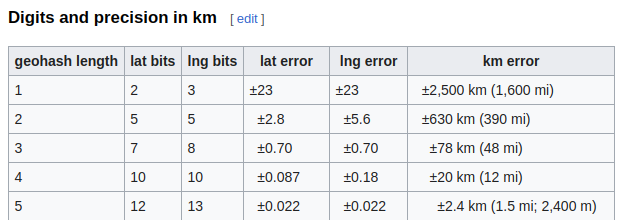

In [4]:
mlab_data_path = "./data/mlab_starlink_data"
csvs = [
    "/city_filtered1_2022-06-01.csv",
    "/city_filtered1_2023-10-01.csv",
    "/city_filtered2_2022-06-01.csv",
    "/city_filtered2_2022-10-01.csv",
    "/city_filtered2_2023-02-01.csv",
    "/city_filtered3_2022-06-01.csv",
    "/city_filtered3_2023-10-01.csv",
    "/city_filtered4.csv",
    "/city_filtered5.csv",
    "/city_filtered6.csv",
    "/city_filtered8.csv",
]

city_df = pd.concat([pd.read_csv(mlab_data_path + csvpath) for csvpath in csvs])

def convert_date(datestr):
    try:
        return datetime.strptime(datestr, '%Y-%m-%d %H:%M:%S.%f %Z')
    except ValueError:
        return datetime.strptime(datestr, '%Y-%m-%d %H:%M:%S %Z')
city_df["a_TestTime"]  = city_df["a_TestTime"].apply(convert_date)
city_df["a_TestMonth"] = city_df["a_TestTime"].apply(lambda date: datetime(year=date.year, month=date.month, day = 1))
city_df["a_DiffRTT"] = city_df["a_MaxRTT"] - city_df["a_MinRTT"]

city_df = city_df[city_df["a_MinRTT"] < 2000] # Discarding outliers. Arbitrary chosen limit of 2000 ms

/tmp/ipykernel_1922007/4245365147.py:16: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  city_df = pd.concat([pd.read_csv(mlab_data_path + csvpath) for csvpath in csvs])
/tmp/ipykernel_1922007/4245365147.py:16: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  city_df = pd.concat([pd.read_csv(mlab_data_path + csvpath) for csvpath in csvs])
/tmp/ipykernel_1922007/4245365147.py:16: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  city_df = pd.concat([pd.read_csv(mlab_data_path + csvpath) for csvpath in csvs])
/tmp/ipykernel_1922007/4245365147.py:16: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  city_df = pd.concat([pd.read_csv(mlab_data_path + csvpath) for csvpath in csvs])


In [360]:
from unidecode import unidecode

# Self defined region
def filter_na(ddf, linktype="down"):
    lon_bound = (-130, -63.6)
    lat_bound = (25, 52)
    
    ddf = ddf[
            ((ddf["client_Geo_Latitude"] > lat_bound[0]) & (ddf["client_Geo_Latitude"] < lat_bound[1])) &
            ((ddf["client_Geo_Longitude"] > lon_bound[0]) & (ddf["client_Geo_Longitude"] < lon_bound[1]))
        ]
    ddf = ddf[ddf["client_Geo_City"].map(unidecode) == ddf["server_Geo_City"].map(unidecode)]
    if linktype == "down":
        ddf = ddf[ddf["isDownload"] == True]
    elif linktype == "up":
        ddf = ddf[ddf["isDownload"] == False]
    
    return ddf

def filter_sa(ddf, linktype="down"):
    lon_bound = (-90, -34)
    lat_bound = (-57.46, 12)

    ddf = ddf[
            ((ddf["client_Geo_Latitude"] > lat_bound[0]) & (ddf["client_Geo_Latitude"] < lat_bound[1])) &
            ((ddf["client_Geo_Longitude"] > lon_bound[0]) & (ddf["client_Geo_Longitude"] < lon_bound[1]))
        ]
    ddf = ddf[ddf["client_Geo_CountryCode"] == ddf["server_Geo_CountryCode"]]
    if linktype == "down":
        ddf = ddf[ddf["isDownload"] == True]
    elif linktype == "up":
        ddf = ddf[ddf["isDownload"] == False]
        
    return ddf

def filter_eu(ddf, linktype="down"):
    lon_bound = (-13, 40)
    lat_bound = (35, 72)
    
    ddf = ddf[
            ((ddf["client_Geo_Latitude"] > lat_bound[0]) & (ddf["client_Geo_Latitude"] < lat_bound[1])) &
            ((ddf["client_Geo_Longitude"] > lon_bound[0]) & (ddf["client_Geo_Longitude"] < lon_bound[1]))
        ]
    ddf = ddf[ddf["client_Geo_CountryCode"] == ddf["server_Geo_CountryCode"]]
    if linktype == "down":
        ddf = ddf[ddf["isDownload"] == True]
    elif linktype == "up":
        ddf = ddf[ddf["isDownload"] == False]
        
    return ddf

def filter_au(ddf, linktype="down"):
    lon_bound = (110, 180)
    lat_bound = (-48.2, -10)

    ddf = ddf[
            ((ddf["client_Geo_Latitude"] > lat_bound[0]) & (ddf["client_Geo_Latitude"] < lat_bound[1])) &
            ((ddf["client_Geo_Longitude"] > lon_bound[0]) & (ddf["client_Geo_Longitude"] < lon_bound[1]))
        ]
    ddf = ddf[((ddf["server_Geo_City"].map(unidecode) == "Sydney") & (ddf["client_Geo_CountryCode"].map(unidecode) == "AU")) | (ddf["client_Geo_CountryCode"].map(unidecode) == ddf["server_Geo_CountryCode"].map(unidecode))]
    if linktype == "down":
        ddf = ddf[ddf["isDownload"] == True]
    elif linktype == "up":
        ddf = ddf[ddf["isDownload"] == False]
        
    return ddf

def filter_mx(ddf, linktype="down"):
    lon_bound = (-118.2,-50)
    lat_bound = (8.3, 28)

    ddf = ddf[
            ((ddf["client_Geo_Latitude"] > lat_bound[0]) & (ddf["client_Geo_Latitude"] < lat_bound[1])) &
            ((ddf["client_Geo_Longitude"] > lon_bound[0]) & (ddf["client_Geo_Longitude"] < lon_bound[1]))
        ]
    if linktype == "down":
        ddf = ddf[ddf["isDownload"] == True]
    elif linktype == "up":
        ddf = ddf[ddf["isDownload"] == False]
        
    return ddf

region_filters = {
    "NA": filter_na,
    "SA": filter_sa,
    "EU": filter_eu,
    "AU": filter_au,
    "MX": filter_mx
}

In [447]:
# Retrieving Starlink Availability scraped from wikipedia
from bs4 import BeautifulSoup
import requests

response = requests.get("https://en.wikipedia.org/wiki/Starlink")
soup = BeautifulSoup(response.text)

countries_soup = soup.find_all("table", attrs={"class": "wikitable"})[1]

countries = []
for a in countries_soup.find_all("tr")[1:]:
    for b in a.find_all("td")[2].find_all("a"):
        countries.append(b.text)
countries.sort()
countries.remove("Czech Republic")
countries.append("Czechia")
countries.remove("United States Virgin Islands")
countries.append("U.S. Virgin Islands")

In [451]:
countries

['Australia',
 'Austria',
 'Bahamas',
 'Belgium',
 'Brazil',
 'Bulgaria',
 'Canada',
 'Chile',
 'Colombia',
 'Croatia',
 'Cyprus',
 'Denmark',
 'Dominican Republic',
 'Easter Island',
 'Ecuador',
 'El Salvador',
 'Estonia',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Guadeloupe',
 'Guatemala',
 'Haiti',
 'Hungary',
 'Iceland',
 'Iran',
 'Ireland',
 'Italy',
 'Jamaica',
 'Japan',
 'Kenya',
 'Latvia',
 'Lithuania',
 'Luxembourg',
 'Malawi',
 'Malaysia',
 'Malta',
 'Martinique',
 'Mexico',
 'Moldova',
 'Mozambique',
 'Netherlands',
 'New Zealand',
 'Nigeria',
 'North Macedonia',
 'Norway',
 'Panama',
 'Peru',
 'Philippines',
 'Pitcairn Islands',
 'Poland',
 'Portugal',
 'Puerto Rico',
 'Romania',
 'Rwanda',
 'Saint Barthélemy',
 'Saint Martin',
 'Slovakia',
 'Slovenia',
 'Spain',
 'Sweden',
 'Switzerland',
 'Tonga',
 'Trinidad and Tobago',
 'Ukraine',
 'United Kingdom',
 'United States',
 'Zambia',
 'Czechia',
 'U.S. Virgin Islands']

In [458]:
import pycountry
countries_map = {}
for country in pycountry.countries:
    countries_map[country.name] = country.alpha_2
    
countries_code = [countries_map.get(country, 'Unknown code') for country in countries]
for code, co in zip(countries_code, countries):
    print(code, co)

AU Australia
AT Austria
BS Bahamas
BE Belgium
BR Brazil
BG Bulgaria
CA Canada
CL Chile
CO Colombia
HR Croatia
CY Cyprus
DK Denmark
DO Dominican Republic
Unknown code Easter Island
EC Ecuador
SV El Salvador
EE Estonia
FI Finland
FR France
DE Germany
GR Greece
GP Guadeloupe
GT Guatemala
HT Haiti
HU Hungary
IS Iceland
Unknown code Iran
IE Ireland
IT Italy
JM Jamaica
JP Japan
KE Kenya
LV Latvia
LT Lithuania
LU Luxembourg
MW Malawi
MY Malaysia
MT Malta
MQ Martinique
MX Mexico
Unknown code Moldova
MZ Mozambique
NL Netherlands
NZ New Zealand
NG Nigeria
MK North Macedonia
NO Norway
PA Panama
PE Peru
PH Philippines
Unknown code Pitcairn Islands
PL Poland
PT Portugal
PR Puerto Rico
RO Romania
RW Rwanda
BL Saint Barthélemy
Unknown code Saint Martin
SK Slovakia
SI Slovenia
ES Spain
SE Sweden
CH Switzerland
TO Tonga
TT Trinidad and Tobago
UA Ukraine
GB United Kingdom
US United States
ZM Zambia
CZ Czechia
Unknown code U.S. Virgin Islands


In [363]:
# Loading RIPE Atlas Probe location
from io import StringIO
ripe_loc_df = pd.read_csv(StringIO("""
place,country_code,latitude,longitude
Mifflinville,US,41.0585,-76.3415
Aldeno,IT,45.9815,11.1005
Friday Harbor,US,48.4785,-122.8605
Maisach,DE,48.2215,11.2575
Pahrump,US,36.2115,-115.9785
Firestone,US,40.1095,-104.9415
Kitzingen,DE,49.7285,10.1485
London,GB,51.5105,-0.1295
York Harbor,US,43.1575,-70.6485
Kettle Falls,US,48.4315,-118.1695
Oneida,US,44.5405,-88.2525
Goldendale,US,45.8415,-120.7095
Fuerstenfeldbruck,DE,48.2015,11.2415
Lalendorf,DE,53.7475,12.3395
Sydney,AU,-33.8715,151.1995
Gambolo,IT,45.2505,8.8605
Greenville,US,40.1205,-120.9015
Woodland,US,45.8985,-122.7395
Lauder,GB,55.6815,-2.7895
Rathdrum,US,47.8115,-116.9005
Millgrove,AU,-37.8315,145.6815
Golden,US,39.7485,-105.2225
Barview,US,43.2505,-124.3915
Henderson,US,35.9515,-115.0215
Nackawic,CA,45.8985,-67.0305
Stattegg,AT,47.1375,15.4515
Berryville,US,39.1005,-77.9625
Brooklyn,US,42.8485,-89.3715
Tairua,NZ,-37.0105,175.8595
De Queen,US,34.2875,-94.2715
Wetaskiwin,CA,53.1285,-113.2085
Scotts Valley,US,37.0415,-121.9915
Beaufort,US,34.7175,-76.6585
Limeil-Brevannes,FR,48.7475,2.4895
Neosho,US,36.8495,-94.3795
Retiro,ES,40.4215,-3.6885
Chicago,US,41.8875,-87.6315
Spencer,US,39.2115,-86.8685
Black Canyon City,US,34.0795,-112.1295
Winlock,US,46.5015,-122.9685
Superior,US,39.9975,-105.2105
Fronton,FR,43.8485,1.3995
Kanwal,AU,-33.2605,151.4785
Durango,US,37.2075,-107.9815
Louvain-la-Neuve,BE,50.6675,4.6185
Zaandam,NL,52.4415,4.8315
Seyne-les-Alpes,FR,44.4075,6.4495
Czarna Woda,PL,53.8295,18.0395
Klagenfurt am Woerthersee,AT,46.6395,14.2915
Limache,CL,-33.0105,-71.2615
Arnprior,CA,45.4575,-76.2025
Butte,US,61.5685,-149.0125
Othello,US,46.7585,-119.1685
Hillsborough,US,36.1185,-79.1605
Sidney,US,40.8585,-102.8625
Nimes,FR,43.8315,4.3215
"""))

### Color / Style Definitions Scheme

In [364]:
continents = ["AF", "AS", "EU", "NA", "OC", "SA"]
cols = plt.get_cmap("tab10").colors
lstyle_array = ["solid", "dotted", "dashed", "dashdot"]

### Helper Functions

In [365]:
import os
def plot_cdf(df, cities, column, xlabel,
                 ax=None,
                 fig=None,
                 show=True,
                 figsize=(7, 4),
                 savefig="",
                 title="CDF",
                 city_colors={},
                 lstyles={},
                 condition=True,
                 skiplegend=False,
                 figures_path="figures", xlim=None, legendsettings={}, legendloc="lower right", xticks=None, xticklabels=None, ylabel="Percentile", stripylabels=False):
    if ax==None:
        fig, ax = plt.subplots(figsize=figsize)
    for city in cities:
        #  & (df["a_MinRTT"] < 600)
        xs = df[(df["client_Geo_City"] == city) & (condition)][column].values
        xs = sorted(xs)
        if len(xs) == 0:
            print(city)
            raise RuntimeError()
        ys = np.arange(1, len(xs) + 1) / len(xs)
        indices = []
        current = xs[0]
        for i, x in enumerate(xs): # only take max y value at each x value to smoothen out the graph
            if x != current:
                current = x
                indices.append(i - 1)
        indices.append(len(ys) - 1)
        xs = sorted(set(xs))
        ys = [ys[i] for i in indices]
        ax.plot(xs, ys, label=city, color=city_colors[city], linestyle=lstyles[city])

    if xlim is not None:
        ax.set_xlim(*xlim)
    if xticks is not None:
        ax.set_xticks(xticks)
    if xticklabels is not None:
        ax.set_xticks(xticklabels)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if stripylabels:
        ax.set_yticks(np.arange(0, 1.25, 0.25), labels=[""]*len(np.arange(0, 1.25, 0.25)))
    else:
        ax.set_yticks(np.arange(0, 1.25, 0.25))
    ax.xaxis.get_major_formatter()._usetex = False
    ax.yaxis.get_major_formatter()._usetex = False

    handles, labels = plt.gca().get_legend_handles_labels()
    sorted_hl = sorted(zip(handles, labels), key=(lambda t: t[1]), reverse=False)
    if not skiplegend:
        ax.legend([t[0] for t in sorted_hl],
                  [t[1] for t in sorted_hl], loc=legendloc, fontsize="small", ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
                  columnspacing=0.5, handletextpad=0.3, fancybox=False)
    ax.grid(True, axis='y', linestyle='-', alpha=0.7, linewidth=0.5)
    
    ax.set_ylim((-0.05, 1.05))

    #plt.title(title)
    if fig != None:
        fig.tight_layout()
    if(savefig != ""):
        if ".pdf" in savefig:
            svg_savefig = savefig.replace(".pdf", ".svg")
            plt.savefig(os.path.join(figures_path, svg_savefig), bbox_inches="tight", pad_inches=0)
        plt.savefig(os.path.join(figures_path, savefig), bbox_inches="tight", pad_inches=0)
    if show:
        plt.show()

In [366]:
def plot_probe_map(city_overview_df, city_df, interesting_cities,
                       lon_bounds = (-180, 180),
                       lat_bounds = (-90, 90),
                       figsize=(7, 6),
                       annotate = True,
                       annotate_minimal = False,
                       savefig = "",
                       figures_path="figures"):
    city_colors = {city: cols[i % len(cols)] for i, city in enumerate(interesting_cities)}
    lstyles = {city: lstyle_array[i % len(lstyle_array)] for i, city in enumerate(interesting_cities)}
    
    client_country_coords_df = city_overview_df.groupby(["ClientCountry", "ClientCity"])[["lat", "lon"]].mean()
    client_country_coords_df = client_country_coords_df[(
                                    client_country_coords_df["lat"] > lat_bounds[0]) & (client_country_coords_df["lat"] < lat_bounds[1]
                                                        )]
    client_country_coords_df = client_country_coords_df[(
                                    client_country_coords_df["lon"] > lon_bounds[0]) & (client_country_coords_df["lon"] < lon_bounds[1]
                                                        )]

    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    world = world[(world.name!="Antarctica")]

    def plotCountryPatch( axes, country_name, fcolor ):
        # plot a country on the provided axes
        nami = world[world.name == country_name]
        namigm = nami.__geo_interface__['features']  # geopandas's geo_interface
        namig0 = {'type': namigm[0]['geometry']['type'], \
                  'coordinates': namigm[0]['geometry']['coordinates']}
        axes.add_patch(PolygonPatch( namig0, fc=fcolor, ec="black", alpha=0.2, zorder=2, linewidth=0.0 ))


    fig, ax = plt.subplots(figsize=figsize, subplot_kw={'projection': ccrs.PlateCarree()})

    ax.set_xlim(lon_bounds)
    ax.set_ylim(lat_bounds)

    cmap = colors.ListedColormap(cols[:-2])
    world.plot(facecolor = "grey", edgecolor="black", ax=ax, linewidth=0.2, alpha=0.2, zorder=0)

    for c in countries:
        c = "United States of America" if c == "United States" else c
        c = "Czechia" if c == "Czech Republic" else c

        if(c in world["name"].values):
            plotCountryPatch(ax, c, "#364aa088")

    client_country_df = city_overview_df.groupby(["ClientCountry", "ClientCity"])[["lat", "lon"]].mean()
    latitude, longitude = client_country_coords_df["lat"], client_country_coords_df["lon"]
    ax.scatter(longitude, latitude, 
                   sizes = [0.7],
                   color="#a8290a88",
                   zorder = 10)

    # Filtered with interesting_cities
    client_country_df = city_overview_df[city_overview_df["ClientCity"].isin(interesting_cities)].groupby(["ClientCountry", "ClientCity"])[["lat", "lon"]].mean()
    latitude, longitude = client_country_df["lat"], client_country_df["lon"]
    ax.scatter(longitude, latitude, 
                   sizes = [10.1],
                   color="green",
                   zorder = 9, marker="x")

    for x, y, label in zip(client_country_coords_df["lon"], client_country_coords_df["lat"], client_country_coords_df.index):
        if(annotate and ((not annotate_minimal) or (label[1] in interesting_cities))):
            ax.annotate(label[1], xy=(x, y), xytext=(-7, 5), textcoords="offset points")

    plt.tight_layout()
    if(savefig != ""):
        if ".pdf" in savefig:
            svg_savefig = savefig.replace(".pdf", ".svg")
            plt.savefig(os.path.join(figures_path, svg_savefig), bbox_inches="tight", pad_inches=0)
        plt.savefig(os.path.join(figures_path, savefig), bbox_inches="tight", pad_inches=0)
    plt.show()

In [367]:
def plot_boxplot_progression(datetime_array, data_array,
                                savefig = "",
                                figsize=(7, 6),
                                ylabel = "",
                                figures_path="figures",
                                nlegendcols=3,
                                ylim=None,
                                xlim=None,
                                decimation=1,
                                orientation="upper right"):
    """
    Plot boxplot progression. As input you give a
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    colnames = data_array[0].keys()
    colcolors = [cols[i] for i, _ in enumerate(data_array[0])]
    def adjust_box(plot):
        for i, (cn, cc) in enumerate(zip(colnames, colcolors)):
            plt.setp(plot['boxes'][i], facecolor=cc, linewidth=1)
            plt.setp(plot['medians'][i], color='yellow')
    
    width = 0.5
    xspan = len(data_array[0].keys()) + 1
    
    for i, (dt, data_dict) in enumerate(zip(datetime_array, data_array)):
        positions = np.arange(
                        i * xspan,
                        i * xspan + len(data_dict.keys())
                    )
        bp = ax.boxplot([data_dict[cn] for cn in colnames], positions=positions, 
                        widths=width, showfliers=False, patch_artist=True)
        adjust_box(bp)

    [ax.axvspan(i * xspan - 1, i * xspan + xspan - 1, facecolor="k", alpha=0.2)
        for i in range(len(datetime_array))
        if i % 2 == 1]

    ax.set_xticks(np.arange(
                        int(xspan / 2),
                        1 + xspan * len(datetime_array),
                        xspan
                    ))
    ax.set_xticklabels([dt.strftime("%Y/%m") for dt in datetime_array])
    ax.xaxis.set_tick_params(rotation=15)
    ax.set_ylabel(ylabel)

    if xlim != None:
        if xlim[1] < 0:
            xlim_ = [xlim[0] * xspan - 1, (len(datetime_array) - 1) * xspan + xspan - 1]
        else:
            xlim_ = [xlim[0] * xspan - 1, (xlim[1] + xlim[0]-1) * xspan + xspan - 1]
        ax.set_xlim(xlim_)
    else:
        ax.set_xlim([-1, (len(datetime_array) - 1) * xspan + xspan - 1])
    if ylim != None:
        ax.set_ylim(ylim)
    #ax.set_yticks(np.arange(0, 700, 100))

    ax.xaxis.get_major_formatter()._usetex = False
    ax.yaxis.get_major_formatter()._usetex = False

    #handles = [Patch(facecolor=continent_colors[target1]), Patch(facecolor=continent_colors[target2]),
    #           Patch(facecolor=continent_colors[cont])]
    handles = [Patch(facecolor=cols[i]) for i, _ in enumerate(data_array[0])]
    labels = colnames
    
    #[label.set_visible(False) for label in ax.xaxis.get_ticklabels()]
    #for label in ax.xaxis.get_ticklabels()[::decimation]:
    #    label.set_visible(True)

    ax.legend(handles, labels, handlelength=1, labelspacing=0.06, columnspacing=0.5, handletextpad=0.3,
              loc=orientation, fancybox=False, edgecolor="k", fontsize="small", ncol=nlegendcols)
    plt.grid(True, axis='y', linestyle='--')

    fig.tight_layout()
    if(savefig != ""):
        if ".pdf" in savefig:
            svg_savefig = savefig.replace(".pdf", ".svg")
            plt.savefig(os.path.join(figures_path, svg_savefig), bbox_inches="tight", pad_inches=0)
        plt.savefig(os.path.join(figures_path, savefig), bbox_inches="tight", pad_inches=0)
    plt.show()

## Big Numbers

In [368]:
# Overall Countries
country_agg_sl_df = pd.read_csv("data/mlab_starlink_country_agg.csv")
used_df = country_agg_sl_df[country_agg_sl_df["count_measurements"] > 1000].reset_index()
used_df = used_df[used_df["CountryName"].isin(countries)]
print("Totally considered number of countries:", len(set(used_df["CountryName"])))
print("Total number of samples considers:", used_df["count_measurements"].sum())

Totally considered number of countries: 34
Total number of samples considers: 19233787


## Monthly Probe Count

In [369]:
from matplotlib import font_manager

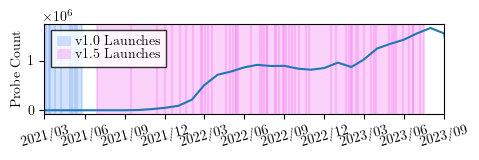

In [370]:
customfont = {'fontname':'CMU Sans Serif'}
matplotlib.rcParams.update({"font.size": 10})

tab_df = pd.read_csv("./data/mlab_starlink_data/ndt7_tableentrystats.csv").set_index("month")
starlink_launchdates = pd.read_csv("./data/gsp_scraped_starlink.csv")
starlink_launchdates["Date"] = starlink_launchdates["Date"].apply(lambda datestr: pd.to_datetime(datestr, format="%Y-%m-%d"))

# Long
#fig, ax = plt.subplots(figsize=(5.33, 2.8))

# Short
fig, ax = plt.subplots(figsize=(5, 1.7))
ax.plot(
    [datetime.fromisoformat(dt) for dt in tab_df.index],
    tab_df["entry_count"],
    color=cols[0]
)

import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%Y/%m')
ax.xaxis.set_major_formatter(myFmt)

# Long
#idx_range = (0, -2)
# Short
idx_range = (26, -2)
ax.set_xlim(
    datetime.fromisoformat(tab_df.index[idx_range[0]]),
    datetime.fromisoformat(tab_df.index[idx_range[1]])
)
tickslist = tab_df.index[idx_range[0]:idx_range[1] + 1][::3]
ax.set_xticks(tickslist)
ax.xaxis.set_tick_params(rotation=15)

def extract_rev_dates(rev):
    return [a for _, a in starlink_launchdates[starlink_launchdates["Revision"] == rev]["Date"].drop_duplicates().items()]
def plot_dates(dates, color, label):
    dates.sort()
    #print(dates)
    # TODO: regions
    if len(dates) == 0:
        return
    elif len(dates) == 1:
        ax.axvline(dates[0], color = color, label = label, zorder=1, alpha=0.3)
    else:
        ax.axvspan(dates[0], dates[-1], label = label, facecolor=color, zorder=1, alpha=0.3)
    for d in dates:
        ax.axvline(d, color = color, zorder=1, alpha=0.3)
        label = ""
    
#plot_dates(extract_rev_dates("v0.9"), color = "#f5ac6c88", label = "v0.9 Launch")
plot_dates(extract_rev_dates("v1.0"), color = "#6ca0f588", label = "v1.0 Launches")
plot_dates(extract_rev_dates("v1.5"), color = "#f56cf088", label = "v1.5 Launches")
#plot_dates(extract_rev_dates("v2-Mini"), color = "#2ce63888", label = "v2 Launch")

#ax.annotate('29', xy=(datetime(year=2021, month=4, day=1), 100000), zorder=5)
#ax.annotate('50', xy=(datetime(year=2022, month=12, day=1), 100000), zorder=5)

plt.legend(loc='upper left', bbox_to_anchor=(0.0, 1.006),
          ncol=1, edgecolor="k", handlelength=1, labelspacing=0.06, columnspacing=0.5, fancybox=False, shadow=False, handletextpad = 0.3)
#ax.legend(loc="lower right", fontsize="small", ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
#          columnspacing=0.5, handletextpad=0.3, fancybox=False)
    
ax.set_ylabel("Probe Count")
#ax.set_xlabel("Test Timestamp")
#plt.title("NDT7 Monthly Starlink Probe Count", **customfont)
plt.tight_layout()
#plt.show()
#plt.savefig('tessstttyyy.png', dpi=300)
plt.savefig("figures/mlab_probecount_withlaunch_short.pdf", pad_inches=0)
plt.savefig("figures/mlab_probecount_withlaunch_short.svg", bbox_inches="tight", pad_inches=0)
plt.show()

## Cities Overview

## Global Probe Map

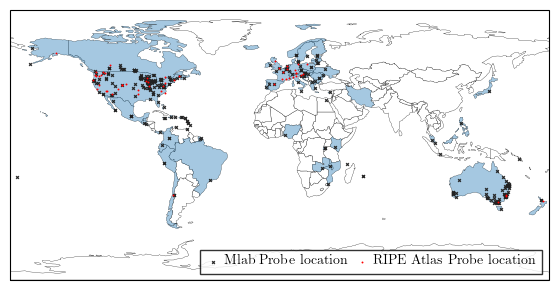

In [371]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
#world = world[(world.name!="Antarctica")]

def plotCountryPatch( axes, country_name, fcolor ):
    # plot a country on the provided axes
    nami = world[world.name == country_name]
    namigm = nami.__geo_interface__['features']  # geopandas's geo_interface
    namig0 = {'type': namigm[0]['geometry']['type'], \
              'coordinates': namigm[0]['geometry']['coordinates']}
    axes.add_patch(PolygonPatch( namig0, fc=fcolor, ec="black", alpha=0.4, zorder=2, linewidth=0.0 ))


fig, ax = plt.subplots(figsize=(7, 3), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = colors.ListedColormap(cols[:-2])
world.plot(facecolor = "white", edgecolor="black", ax=ax, linewidth=0.2, alpha=1.0, zorder=0)

for c in countries:
    c = "United States of America" if c == "United States" else c
    c = "Czechia" if c == "Czech Republic" else c
    
    if(c in world["name"].values):
        plotCountryPatch(ax, c, matplotlib.colors.to_hex(cols[0]))
    #else:
    #    print(c)

def plot_extent(inclination, color="r", lw=1.4, alpha=0.7, lt="dotted"):
    label = "{}°".format(inclination)
    if inclination > 90:
        inclination = 90 - (inclination % 90)
    plt.plot([-180, 180], [ inclination,  inclination], linewidth=lw, color=color, linestyle=lt, alpha=alpha, label=label)
    plt.plot([-180, 180], [-inclination, -inclination], linewidth=lw, color=color, linestyle=lt, alpha=alpha)

#plot_extent(53, "r", lt="dotted", lw=0.8)
#plot_extent(70, "g", lt="dashed", lw=0.8)
#plot_extent(97.6, "b", lt="dashdot", lw=0.8)

#for x, y, label in zip(ndt7_df["lon"], ndt7_df["lat"], ndt7_df["ClientCountry"]):
#    ax.annotate(
#                    label,
#                    xy=(x, y),
#                    xytext=(2, 2),
#                    textcoords="offset points",
#                    fontsize=5
#    )
    

#ax.legend(loc='lower right', bbox_to_anchor=(1.00, -0.002),
#        ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06, columnspacing=0.5, fancybox=False, shadow=False, handletextpad = 0.3)
# ncol=3, fancybox=True, shadow=False)

#ax2 = ax.twinx()

latitude, longitude = ndt7_df["lat"], ndt7_df["lon"]
ax.scatter(longitude, latitude, 
               sizes = [6],
               linewidth = 0.1,
               color="#222222",
               zorder = 10,
                marker="X", label="Mlab Probe location")

latitude, longitude = ripe_loc_df["latitude"], ripe_loc_df["longitude"]
ax.scatter(longitude, latitude, 
               sizes = [1.5],
               linewidth = 0.1,
               color="#FF0000",
               zorder = 11,
                marker="o", label="RIPE Atlas Probe location")

ax.legend(loc='lower right', bbox_to_anchor=(1.00, -0.002),
        ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06, columnspacing=0.5, fancybox=False, shadow=False, handletextpad = 0.3)

ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

#ax2.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
#ax2.get_xaxis().set_ticks([])
#ax2.get_yaxis().set_ticks([])

plt.tight_layout()
plt.savefig("figures/mlab_probecities_overview_map.pdf")
plt.show()


# TODO:
# - Introduction: mention IP geolocation, GW locations, regions (AU, EU, NA, SA) SA AU EU NA 
# - Finish writing the paper report with that global collection and also use the coverage map

# TODO [ ]
# Filter out properly like discussed in skype (EU, SA <-> US, SA)
# Minrtt & htroughput globall
# Minrtt for regions individually
# Filter out cities not connecting with server from same city
# Endproduct: CDFs like now

# TODO: [ ] Check a fixed time periods and two regions
# fixed period -> Where the service starlink recently launched (maybe Ukraine) right after operational
# Compare with Country where it has been operational for a longer while
# Endproduct: Boxplot Time comparison, see sketch below. TBD which cities

# TODO: [ ] MNO analysis
# General comparison with mobile ISPs with Mlab data
# Filter out arm/android/ios OS -> Filter out server client not same city -> Which ASN do they have -> Which MNO do they belong -> Which MNO is most used per country? -> Filter out less popular MNO 
# -> Compare the MinRTT thorughput with Starlink probes
# Endprooduct: Boxplot per City

# TODO: [ ] coordinate histogram
# Endproduct: Map

# TODO: [ ] Weather Report, TBD on exact plots

# TODO: overlead TODOs
# Section 2
# TODO: add to overleaf and own paper: Coverage Map and 3d render

These are countries Outside of 53° latitude region. However: no probe is from outside of 53° coverage if we consider the line of sight coverage, even with 15° min elevation.

Loading the detailed city dataset

In [372]:
city_df.groupby(["client_Geo_City"])[["id"]].count().sort_values(by="id", ascending=False)

,id
client_Geo_City,
Seattle,1672641
Chicago,1623618
Toronto,1451554
Dallas,1417043
Los Angeles,1216640
...,...
Lara,5
Peelhurst,5
Rainbow Beach,4


## Stats ClientCity = ServerCity

In [373]:
# City List of cities with same client city as server city within filtered for Starlink probes with count of probes
from io import StringIO

pd.read_csv(StringIO("""
City with =	ProbeCount
Seattle	1220398
Chicago	1098253
Dallas	1038789
Atlanta	1009239
Los Angeles	918749
Toronto	761947
New York	740475
Sydney	659755
London	445902
Denver	440671
Mexico City	271860
Vancouver	188437
Auckland	96986
Montreal	87032
Calgary	83214
Paris	65717
Santiago	61471
Dublin	61340
Winnipeg	52273
Madrid	33761
Brussels	18461
Lisbon	14139
Prague	10054
Tokyo	8758
Amsterdam	7379
Lagos	7266
Lima	1697
Stockholm	658
Athens	193
Warsaw	130
Manila	78
Sofia	47
Maputo	31
Ljubljana	20
Jakarta	9
"""), delimiter="	")

,City with =,ProbeCount
0,Seattle,1220398
1,Chicago,1098253
2,Dallas,1038789
3,Atlanta,1009239
4,Los Angeles,918749
5,Toronto,761947
6,New York,740475
7,Sydney,659755
8,London,445902
9,Denver,440671


In [374]:
# City List of cities with same client city as server city within filtered for Starlink probes with count of probes
from io import StringIO

pd.read_csv(StringIO("""
City with !=,ProbeCount
Calgary,169254
Berlin,156570
São Paulo,154214
Winnipeg,86589
Rome,77123
Vienna,14113
Bogotá,13813
Auckland,12705
Chicago,11002
Lagos,9702
Sydney,8588
Toronto,8445
New York,6267
Dublin,5862
Los Angeles,4669
Atlanta,4582
Dallas,4382
Santo Domingo,4220
Seattle,4067
Mexico City,2743
Denver,2603
Fort-de-France,2335
Tokyo,2278
Charlotte Amalie,1973
Hampton,1622
San Juan,1339
Gustavia,1291
Vancouver,1282
Oslo,1269
London,1255
Warsaw,1145
Kyiv,835
Newaygo,827
Danbury,743
Montreal,713
Perth,627
Basse-Terre,624
Marigot,560
Kingston,552
Madrid,505
Shelburn,494
Lisbon,457
Hunnewell,445
Noojee,434
Wrenshall,411
Nuku'alofa,387
Fall River Mills,380
Paris,380
Howell,342
Kellevie,342
Santiago,311
Bororen,258
Pleasant View,256
Prague,244
Morganfield,235
Kalispell,224
Yinnar South,194
Mazomanie,190
Dorr,181
Adelaide Hills,163
Saint-Denis,158
Jakarta,154
Evansville,134
Copenhagen,100
Bucharest,99
Cayenne,96
Bratislava,95
Madison,79
Tallinn,75
Brussels,66
Zagreb,64
South Bend,59
Dedham,57
Huson,51
Riga,50
Lima,47
Fond du Lac,47
Rutherglen,44
Cairo,34
Vilnius,32
Eyota,30
Amsterdam,29
Mount Shasta,28
Andenne,26
Chippewa Falls,25
Athens,25
Kigali,21
Zurich,20
Budapest,20
Mandurah,16
Booroobin,15
Ljubljana,13
St Peter Port,11
Willemstad,9
M'Sapere,9
Corrigin,7
Manila,6
Sofia,6
Chisinau,6
Silverwood,6
Benayeo,5
Valletta,4
Bridgetown,4
Stockholm,4
Skopje,2
Myrtle Point,1
"""))[:15]

,City with !=,ProbeCount
0,Calgary,169254
1,Berlin,156570
2,São Paulo,154214
3,Winnipeg,86589
4,Rome,77123
5,Vienna,14113
6,Bogotá,13813
7,Auckland,12705
8,Chicago,11002
9,Lagos,9702


## IP Geolocation spread

The spread of IP geolocation is not even. In later cells, you will see that only the US, Australia, Canada, and Belgium have more than two cities geolocated by the IP annotator. I never got around to inspect the IP annotator in closer detail as to why this is, there is also the issue that I don't know exactly which IP annotator added the information to the ndt row (because it might change).

In [375]:
temp_df = ndt7_df.groupby(["ClientCountry", "ClientCity"])[["MeasurementCount"]].sum()
temp_df.reset_index().groupby(["ClientCountry"])[["ClientCity"]].count().sort_values(by="ClientCity", ascending=False)

,ClientCity
ClientCountry,
United States,83
Australia,54
Canada,16
Mexico,4
Belgium,2
...,...
Guatemala,1
Guadeloupe,1
Greece,1


The generated maps are generated here somewhere. I put this in this cell again as raw image just so we see the spread again

Spread in US:

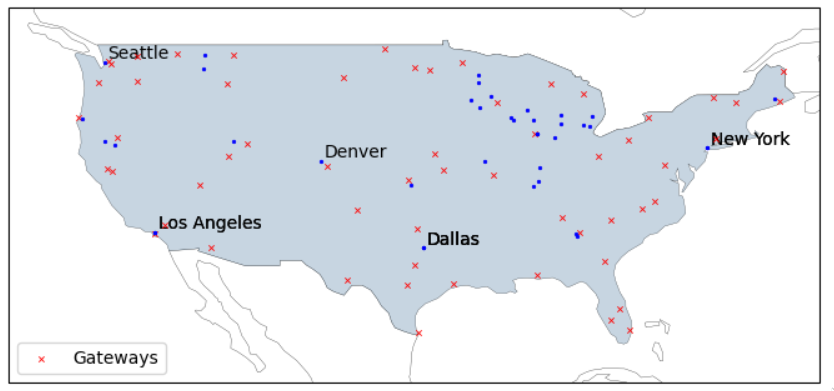

Spread in EU:

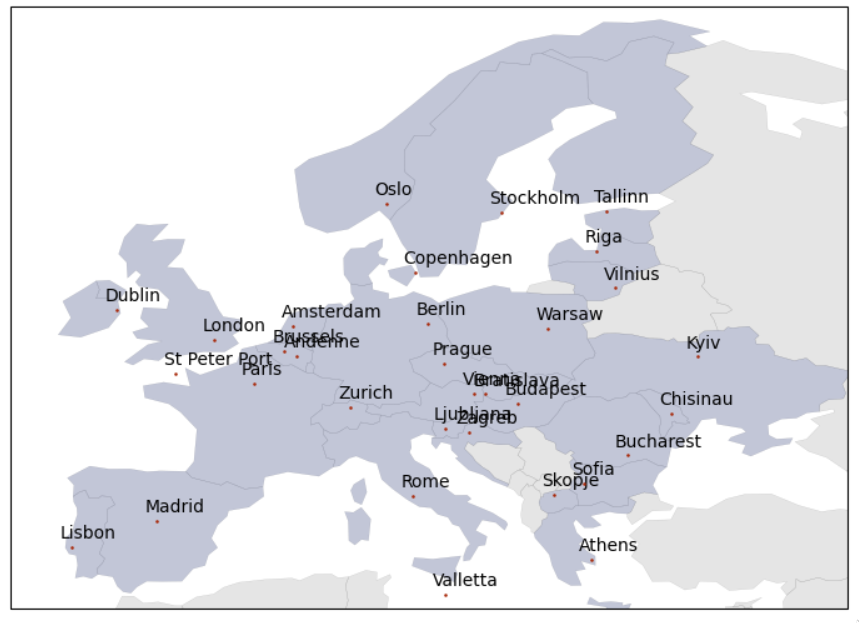

Spread in AU:

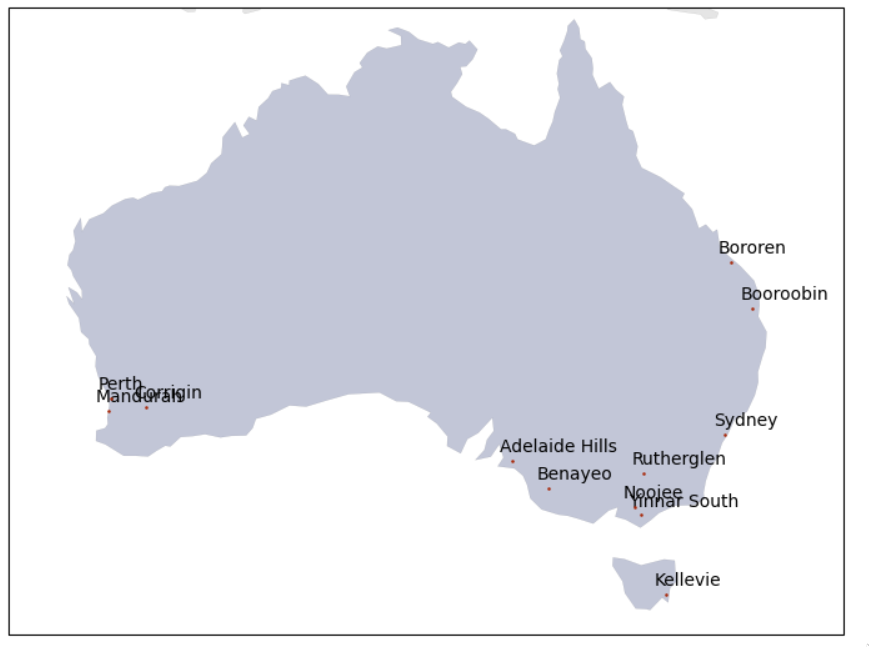

## Defining Global City Color and City Linestyle

In [376]:
lstyle_array

['solid', 'dotted', 'dashed', 'dashdot']

In [377]:
def assign_style(cityname):
    cols = plt.get_cmap("tab10").colors
    linestyle_array = ['solid', 'dotted', 'dashed', 'dashdot']
    
    offsetcolor = 0
    offsetline = 0
    
    if cityname == "New York":
        offsetcolor = -1
    elif cityname == "Seattle":
        offsetcolor = 2
    elif cityname == "Mexico City":
        offsetcolor = 1
    elif cityname == "Lima":
        offsetcolor = 2
        offsetline = 2
    elif cityname == "Paris":
        offsetcolor = 1
        offsetline = 12
    elif cityname == "London":
        offsetcolor = 2
        offsetline = 3
    elif cityname == "Perth":
        offsetcolor = 2
        offsetline = 3
    elif cityname == "Bororen":
        offsetcolor = 1
        offsetline = 12
    
    return cols[(offsetcolor + abs(hash(cityname))) % len(cols)], linestyle_array[(offsetline + abs(hash(cityname))) % len(linestyle_array)]

cities = city_df["client_Geo_City"].drop_duplicates().values
city_colors = {city: assign_style(city)[0] for city in city_df["client_Geo_City"].drop_duplicates().values}
lstyles = {city: assign_style(city)[1] for city in city_df["client_Geo_City"].drop_duplicates().values}

## 5 NA Cities

- Seattle
- Denver
- Dallas
- New York
- Los Angeles

In [378]:
interesting_cities = [
    "Seattle",
    "Denver",
    "Dallas",
    "New York",
    "Los Angeles"
]
interesting_cities = sorted(interesting_cities)

#city_colors = {
#            "Seattle"     : "#7598b6",
#            "Denver"      : "#914c09",
#            "Los Angeles" : "#ce9c7f",
#            "Dallas"      : "#c1d5e2", 
#            "New York"    : "#663979"
#                }
#lstyles = {
#            "Seattle"     : "dotted",
#            "Denver"      : "solid",
#            "Los Angeles" : "dashed",
#            "Dallas"      : "solid", 
#            "New York"    : "dashdot"
#                }

city_colors = {city: cols[i % len(cols)] for i, city in enumerate(interesting_cities)}
lstyles = {city: lstyle_array[i % len(lstyle_array)] for i, city in enumerate(interesting_cities)}

df = region_filters["NA"](city_df)

In [379]:
for c in interesting_cities:
    print("========== {} ===========".format(c))
    print(
        df[
            df["client_Geo_City"] == c
        ][
            ["id", "server_Geo_City"]
        ].groupby("server_Geo_City").count().sort_values("id", ascending=False)[:10]
    )
    print("===========================")

========== Dallas ===========
                     id
server_Geo_City        
Dallas           787059
========== Denver ===========
                     id
server_Geo_City        
Denver           384833
========== Los Angeles ===========
                     id
server_Geo_City        
Los Angeles      667858
========== New York ===========
                     id
server_Geo_City        
New York         579321
========== Seattle ===========
                     id
server_Geo_City        
Seattle          904411


In [380]:
temp_df = ndt7_df.groupby(["ClientCountry", "ClientCity"])[["MeasurementCount"]].sum()
temp_df.loc["United States",:].sort_values(by="MeasurementCount", ascending=False)[:10]

,MeasurementCount
ClientCity,
Seattle,1950319
Chicago,1891815
Dallas,1651048
Atlanta,1628907
Los Angeles,1415816
New York,1231790
Denver,825782
West Newton,13059
Rixeyville,4535


### Map

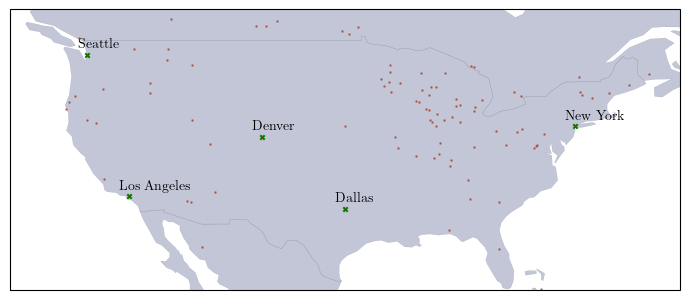

In [381]:
lon_bounds = (-130, -63.6)
lat_bounds = (25, 52)

plot_probe_map(ndt7_df, city_df, interesting_cities,
                   lon_bounds = lon_bounds,
                   lat_bounds = lat_bounds,
                   annotate_minimal=True)

### Analysis

In [382]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

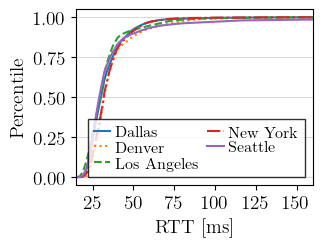

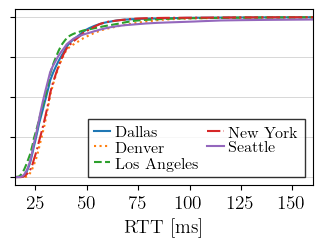

In [383]:
matplotlib.rcParams.update({"font.size": 14})
plot_cdf(df[df["isDownload"] == True], interesting_cities, "a_MinRTT", "RTT [ms]", xlim=(15, 160), xticks=[25, 50, 75, 100, 125, 150],
         figsize=(3.45, 2.7), savefig="mlab_cdf_minrtt_5nacities.pdf", city_colors=city_colors, lstyles=lstyles)
plot_cdf(df[df["isDownload"] == True], interesting_cities, "a_MinRTT", "RTT [ms]", xlim=(15, 160), ylabel="", stripylabels=True, xticks=[25, 50, 75, 100, 125, 150],
         figsize=(3.45, 2.7), savefig="mlab_cdf_minrtt_5nacities_stripped.pdf", city_colors=city_colors, lstyles=lstyles)
#plot_cdf(df, interesting_cities, "a_MeanThroughputMbps", "Mean Throughput [Mbps]", figsize=(2.8, 2), city_colors=city_colors, lstyles=lstyles)
#plot_cdf(df, interesting_cities, "a_MedianThroughputMbps", "Throughput [Mbps]", figsize=(2.8, 2), city_colors=city_colors, lstyles=lstyles)
#plot_cdf(df, interesting_cities, "a_LossRate", "Loss Rate [0-1]", figsize=(2.8, 2), city_colors=city_colors, lstyles=lstyles)

## Mexico-Adjacent (Name suggestions welcome)

In [384]:
interesting_cities = [
                "Mexico City"]
interesting_cities = sorted(interesting_cities)

city_colors = {city: cols[i % len(cols)] for i, city in enumerate(interesting_cities)}

lstyles = {city: lstyle_array[i % len(lstyle_array)] for i, city in enumerate(interesting_cities)}

df = city_df[ 
    city_df["client_Geo_City"].isin(interesting_cities)
]

### Map

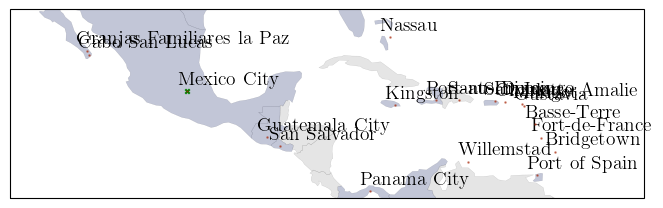

In [385]:
plot_probe_map(ndt7_df, city_df, interesting_cities,
                   lon_bounds = (-118.2,-50),
                   lat_bounds = (8.3, 28),
                   annotate_minimal=False)

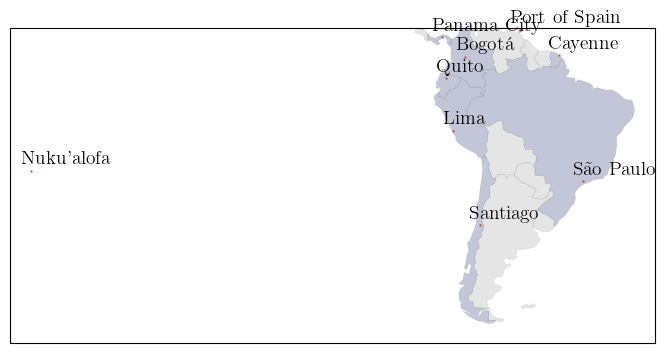

In [386]:
plot_probe_map(ndt7_df, city_df, interesting_cities,
                   lon_bounds = (-180,-30),
                   lat_bounds = (-60, 11),
                   annotate_minimal=False)

## 4 South American Cities
- São Paulo (BRA)
- Santiago (CHL)
- Bogotá (COL) 
- Lima (PRE)

In [387]:
interesting_cities = [
                "São Paulo",
                "Santiago",
                "Bogotá",
                "Lima"]
interesting_cities = sorted(interesting_cities)

city_colors = {city: cols[i % len(cols)] for i, city in enumerate(interesting_cities)}

lstyles = {city: lstyle_array[i % len(lstyle_array)] for i, city in enumerate(interesting_cities)}

df = region_filters["SA"](city_df)

In [388]:
df.groupby("client_Geo_City").count()

,id,date,isDownload,server_Site,server_Geo_CountryCode,server_Geo_CountryName,server_Geo_City,server_Geo_Latitude,server_Geo_Longitude,server_Network_CIDR,...,a_LossRate,a_MaxRTT,GoodputMedian,GoodputMean,ThroughputMedian,ThroughputMean,client_Network_ASNumber,a_MedianThroughputMbps,a_TestMonth,a_DiffRTT
client_Geo_City,,,,,,,,,,,,,,,,,,,,,
Bogotá,37842,37842,37842,37842,37842,0,37842,37842,37842,37842,...,37842,37842,37842,37842,37842,37842,0,0,37842,37842
Lima,17554,17554,17554,17554,17554,0,17554,17554,17554,17554,...,17554,17554,17554,17554,17554,17554,0,0,17554,17554
Santiago,53830,53830,53830,53830,53830,0,53830,53830,53830,53830,...,53830,53830,53830,53830,53830,53830,0,0,53830,53830
São Paulo,424259,424259,424259,424259,424259,0,424259,424259,424259,424259,...,424259,424259,424259,424259,424259,424259,0,0,424259,424259


In [389]:
for c in interesting_cities:
    print("========== {} ===========".format(c))
    print(
        df[
            df["client_Geo_City"] == c
        ][
            ["id", "server_Geo_CountryCode"]
        ].groupby("server_Geo_CountryCode").count().sort_values("id", ascending=False)[:10]
    )
    print("===========================")

========== Bogotá ===========
                           id
server_Geo_CountryCode       
CO                      37842
========== Lima ===========
                           id
server_Geo_CountryCode       
PE                      17554
========== Santiago ===========
                           id
server_Geo_CountryCode       
CL                      53830
========== São Paulo ===========
                            id
server_Geo_CountryCode        
BR                      424259


### Map

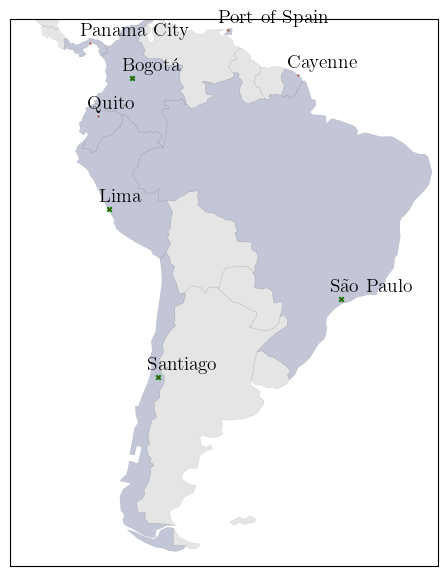

In [390]:
plot_probe_map(ndt7_df, city_df, interesting_cities,
                   lat_bounds = (-57.46, 12),
                   lon_bounds = (-90, -34),
                   annotate_minimal=False)

### CDF

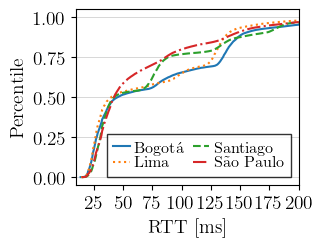

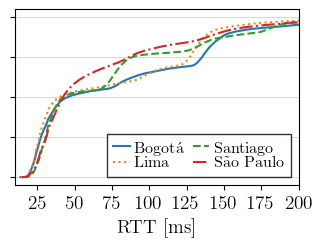

In [391]:
matplotlib.rcParams.update({"font.size": 14})
plot_cdf(df[df["isDownload"] == True], interesting_cities, "a_MinRTT", "RTT [ms]", xticks=[25, 50, 75, 100, 125, 150, 175, 200],
             figsize=(3.45, 2.7), city_colors=city_colors, lstyles=lstyles, savefig="mlab_cdf_minrtt_5sacities.pdf", xlim=(10, 200))
plot_cdf(df[df["isDownload"] == True], interesting_cities, "a_MinRTT", "RTT [ms]", xticks=[25, 50, 75, 100, 125, 150, 175, 200],
             figsize=(3.45, 2.7), city_colors=city_colors, lstyles=lstyles, savefig="mlab_cdf_minrtt_5sacities_stripped.pdf", xlim=(10, 200), ylabel="", stripylabels=True)
#plot_cdf(df, interesting_cities, "a_MeanThroughputMbps", "Median Throughput [Mbps]", 
#             figsize=(2.8, 2), city_colors=city_colors, lstyles=lstyles)
#plot_cdf(df, interesting_cities, "a_MedianThroughputMbps", "Throughput [Mbps]", 
#             figsize=(2.8, 2), city_colors=city_colors, lstyles=lstyles)
#plot_cdf(df, interesting_cities, "a_LossRate", "Loss Rate [0-1]", 
#             figsize=(2.8, 2), city_colors=city_colors, lstyles=lstyles)

## 6 EU Cities

- Dublin, Ireland
- London, United Kingdom
- Berlin, Germany
- Kyiv, Ukraine
- Paris, France
- Rome, Italy

In [392]:
interesting_cities = [
                "Dublin",
                "London",
                "Berlin",
                "Paris",
                "Rome"]
interesting_cities = sorted(interesting_cities)

city_colors = {city: cols[i % len(cols)] for i, city in enumerate(interesting_cities)}

lstyles = {city: lstyle_array[i % len(lstyle_array)] for i, city in enumerate(interesting_cities)}

#city_colors = {
#            "Sydney"       : "#7598b6",
#            "Perth"        : "#914c09",
#            "Noojee"       : "#ce9c7f",
#            "Kellevie"     : "#c1d5e2", 
#            "Bororen"      : "#663979"
#                }

#lstyles = {
#            "Sydney"       : "dotted",
#            "Perth"        : "solid",
#            "Noojee"       : "dashed",
#            "Kellevie"     : "solid", 
#            "Bororen"      : "dashdot"
#                }

df = region_filters["EU"](city_df)

In [393]:
for c in interesting_cities:
    print("========== {} ===========".format(c))
    print(
        df[
            df["client_Geo_City"] == c
        ][
            ["id", "server_Geo_CountryCode"]
        ].groupby("server_Geo_CountryCode").count().sort_values("id", ascending=False)[:10]
    )
    print("===========================")

========== Berlin ===========
                            id
server_Geo_CountryCode        
DE                      121992
========== Dublin ===========
                           id
server_Geo_CountryCode       
IE                      46225
========== London ===========
                            id
server_Geo_CountryCode        
GB                      508599
========== Paris ===========
                            id
server_Geo_CountryCode        
FR                      138875
========== Rome ===========
                            id
server_Geo_CountryCode        
IT                      101025


### Map

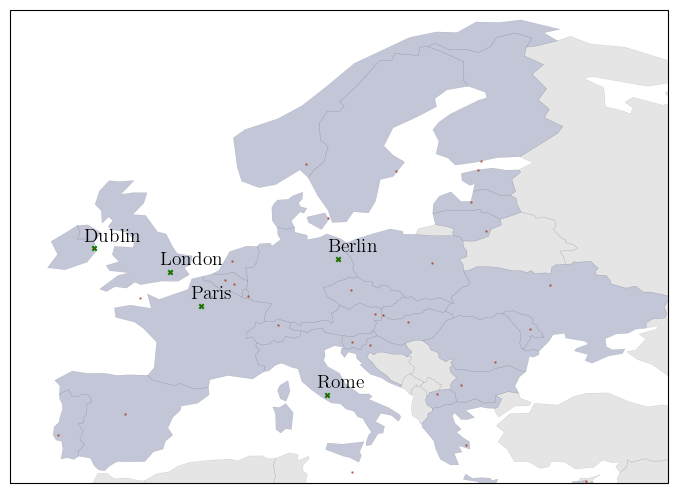

In [394]:
plot_probe_map(ndt7_df, city_df, interesting_cities,
                   lat_bounds = (35, 72),
                   lon_bounds = (-13, 40),
                   annotate_minimal=True)

### Analysis

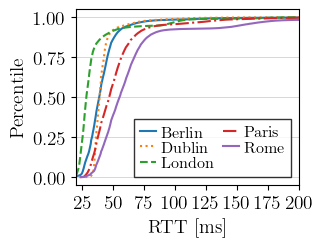

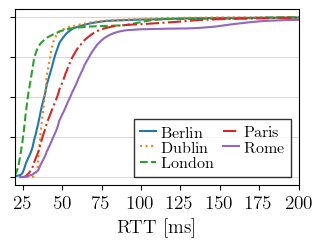

In [395]:
matplotlib.rcParams.update({"font.size": 14})
plot_cdf(df, interesting_cities, "a_MinRTT", "RTT [ms]", xticks=[25, 50, 75, 100, 125, 150, 175, 200],
             figsize=(3.45, 2.7), city_colors=city_colors, lstyles=lstyles, savefig="mlab_cdf_minrtt_eucities.pdf", xlim=(20, 200))
plot_cdf(df, interesting_cities, "a_MinRTT", "RTT [ms]", xticks=[25, 50, 75, 100, 125, 150, 175, 200],
             figsize=(3.45, 2.7), city_colors=city_colors, lstyles=lstyles, savefig="mlab_cdf_minrtt_eucities_stripped.pdf", xlim=(20, 200), ylabel="", stripylabels=True)
#plot_cdf(df[df["isDownload"] == True], interesting_cities, "GoodputMean", "Mean Throughput [Mbps]", 
#             figsize=(2.8, 2), city_colors=city_colors, lstyles=lstyles, savefig="cdf_meangoodput_eucities.pdf")
#plot_cdf(df, interesting_cities, "a_MedianThroughputMbps", "Throughput [Mbps]", 
#             figsize=(2.8, 2), city_colors=city_colors, lstyles=lstyles, savefig="cdf_medianthroughput_eucities.pdf")
#plot_cdf(df, interesting_cities, "a_LossRate", "Loss Rate [0-1]", 
#             figsize=(2.8, 2), city_colors=city_colors, lstyles=lstyles, savefig="cdf_lossrate_eucities.pdf")

## 5 Australian Cities

> Note: In terms of diversity of the IP geolocations, australie is the most diverse after the US. Outsie of Belgium, Canada, Australia, United States, other countries in the Mlab dataset only have one city per country as IP geolocation.

- Sydney, 666734
- Perth, 627
- Noojee, 434
- Kellevie, 342
- Bororen, 258
- Yinnar South, 194
- Adelaide Hills, 163

In [396]:
interesting_cities = [
                "Sydney",
                "Perth",
                "Noojee",
                "Kellevie",
                "Auckland"]
interesting_cities = sorted(interesting_cities)

city_colors = {city: cols[i % len(cols)] for i, city in enumerate(interesting_cities)}

lstyles = {city: lstyle_array[i % len(lstyle_array)] for i, city in enumerate(interesting_cities)}

df = region_filters["AU"](city_df)
#df = city_df

In [397]:
temp_df = ndt7_df.groupby(["ClientCountry", "ClientCity"])[["MeasurementCount"]].sum()
temp_df.loc["Australia",:].sort_values(by="MeasurementCount", ascending=False)

,MeasurementCount
ClientCity,
Sydney,1119928
Perth,67427
Ballarat,2869
Noojee,572
Moss Vale,475
Kellevie,380
Adelaide Hills,336
Port Augusta,328
Corrigin,284


In [398]:
for c in interesting_cities:
    print("========== {} ===========".format(c))
    print(
        df[
            df["client_Geo_City"] == c
        ][
            ["id", "server_Geo_City"]
        ].groupby("server_Geo_City").count().sort_values("id", ascending=False)[:10]
    )
    print("===========================")

========== Auckland ===========
                    id
server_Geo_City       
Auckland         60404
Wellington       21608
========== Kellevie ===========
                  id
server_Geo_City     
Sydney           183
========== Noojee ===========
                  id
server_Geo_City     
Sydney           294
Melbourne          2
========== Perth ===========
                    id
server_Geo_City       
Perth            21951
Sydney            3368
Melbourne         1848
========== Sydney ===========
                     id
server_Geo_City        
Sydney           533035
Melbourne          2634
Perth              1190


### Map

In [399]:
city_df["client_Geo_City"].drop_duplicates().values

array(['Sydney', 'Mexico City', 'Seattle', 'Bogotá', 'Oslo', 'Calgary',
       'Berlin', 'Toronto', 'Chicago', 'Denver', 'Los Angeles', 'Dallas',
       'New York', 'Santiago', 'São Paulo', 'Lima', "Nuku'alofa", 'Rome',
       'Perth', 'Paris', 'Wollongong', 'Brisbane', 'South Melbourne',
       'London', 'Kyiv', 'Noojee', 'Ballarat', 'Adelaide Hills',
       'Narrikup', 'Rutherglen', 'Booroobin', 'Tolga', 'Yinnar South',
       'Bororen', 'Dublin', 'Port Augusta', 'St Fillans', 'Marree',
       'Mandurah', 'Sunshine Coast', 'Paris Creek', 'Hervey Bay',
       'Geelong', 'Corrigin', 'Kellevie', 'Cobden', 'Benayeo', 'Yarraman',
       'Marysville', 'Leongatha', 'Nyah', 'Cryon', 'Kenthurst',
       'Bundanoon', 'Moss Vale', 'Melbourne', 'Kogan', 'Ryde',
       'Somerset Dam', 'Palmwoods', 'Maitland', 'Orangeville',
       'North Star', 'Mackay', 'Keerong', 'Crows Nest', 'Logan City',
       'Mudgee', 'Newman', 'Rainbow Beach', 'Kew', 'Lara', 'Peelhurst',
       'High Range', 'Flinders', 

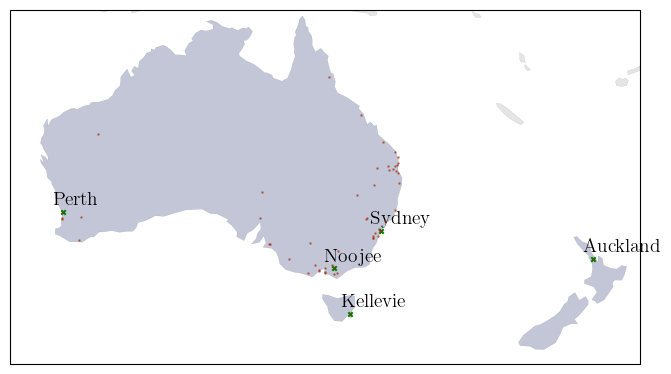

In [400]:
plot_probe_map(ndt7_df, city_df, interesting_cities,
                   lat_bounds = (-48.2, -10),
                   lon_bounds = (110, 180),
                   annotate_minimal=True)

### CDF

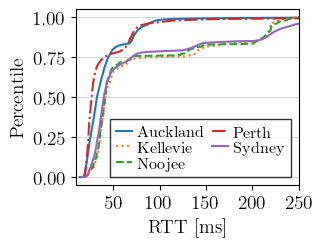

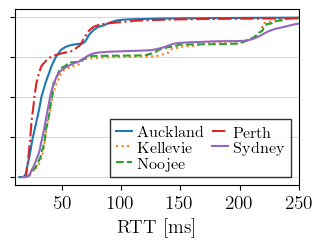

In [401]:
matplotlib.rcParams.update({"font.size": 14})
plot_cdf(df[df["isDownload"] == True], interesting_cities, "a_MinRTT", "RTT [ms]",
             figsize=(3.45, 2.7), city_colors=city_colors, lstyles=lstyles, xlim=(10, 250), savefig="mlab_cdf_minrtt_5aucities.pdf", xticks=[50, 100, 150, 200, 250])
plot_cdf(df[df["isDownload"] == True], interesting_cities, "a_MinRTT", "RTT [ms]", xticks=[50, 100, 150, 200, 250],
             figsize=(3.45, 2.7), city_colors=city_colors, lstyles=lstyles, savefig="mlab_cdf_minrtt_5aucities_stripped.pdf", xlim=(10, 250), ylabel="", stripylabels=True)
#plot_cdf(df, interesting_cities, "a_MeanThroughputMbps", "Mean Throughput [Mbps]", 
#             figsize=(2.8, 2), city_colors=city_colors, lstyles=lstyles, savefig="cdf_meanthroughput_5aucities.pdf")
#plot_cdf(df, interesting_cities, "a_MedianThroughputMbps", "Throughput [Mbps]", 
#             figsize=(2.8, 2), city_colors=city_colors, lstyles=lstyles, savefig="cdf_medianthroughput_5aucities.pdf")
#plot_cdf(df, interesting_cities, "a_LossRate", "Loss Rate [0-1]", 
#             figsize=(2.8, 2), city_colors=city_colors, lstyles=lstyles, savefig="cdf_lossrate_5aucities.pdf")

## 5 Global City Overview

- Seattle (USA)
- Mexico City (MEX)
- Bogotá (COL)
- Sydney (AUS)
- Dublin ()

In [402]:
sstr = "WHERE \n(\n{}\n)".format(" AND\n".join(
    ["\t(client.Geo.CountryName != \"{}\")".format(cn) for cn in city_df["client_Geo_CountryName"].drop_duplicates().values]
))

print(sstr)

WHERE 
(
	(client.Geo.CountryName != "Australia") AND
	(client.Geo.CountryName != "Mexico") AND
	(client.Geo.CountryName != "United States") AND
	(client.Geo.CountryName != "Colombia") AND
	(client.Geo.CountryName != "Norway") AND
	(client.Geo.CountryName != "Canada") AND
	(client.Geo.CountryName != "Germany") AND
	(client.Geo.CountryName != "Chile") AND
	(client.Geo.CountryName != "Brazil") AND
	(client.Geo.CountryName != "Peru") AND
	(client.Geo.CountryName != "Tonga") AND
	(client.Geo.CountryName != "Italy") AND
	(client.Geo.CountryName != "France") AND
	(client.Geo.CountryName != "United Kingdom") AND
	(client.Geo.CountryName != "Ukraine") AND
	(client.Geo.CountryName != "Ireland") AND
	(client.Geo.CountryName != "Sweden") AND
	(client.Geo.CountryName != "New Zealand") AND
	(client.Geo.CountryName != "El Salvador") AND
	(client.Geo.CountryName != "Martinique") AND
	(client.Geo.CountryName != "Jamaica") AND
	(client.Geo.CountryName != "Guatemala") AND
	(client.Geo.CountryName != "Ha

In [419]:
interesting_cities = [
        "Mexico City",
        "São Paulo",
        "Seattle",
        "Sydney",
        "Dublin",
        "Lagos",
        "Manila"
]
interesting_cities=sorted(interesting_cities)
# Kyiv filtered out because it would be an interesting side-analysis

city_colors = {city: cols[i % len(cols)] for i, city in enumerate(interesting_cities)}

lstyles = {city: lstyle_array[i % len(lstyle_array)] for i, city in enumerate(interesting_cities)}

df = city_df[ 
    city_df["client_Geo_City"].isin(interesting_cities)
]

# Filter out not same city / country
from unidecode import unidecode
df = df[((df["client_Geo_City"].map(unidecode) == df["server_Geo_City"].map(unidecode)) & df["client_Geo_CountryCode"].isin(["US", "AU"])) | (df["client_Geo_CountryCode"] == df["server_Geo_CountryCode"])]

down_df = df[df["isDownload"] == True]
up_df = df[df["isDownload"] == False]

# Execute below code to see to which cities a city connects to
#for city in interesting_cities:
#    print("===========================")
#    print(city)
#    print(df[df["client_Geo_City"] == city].groupby(["server_Geo_City"])[["id"]].count().sort_values(by="id", ascending=False)[:5])
#    print("===========================")

### Map

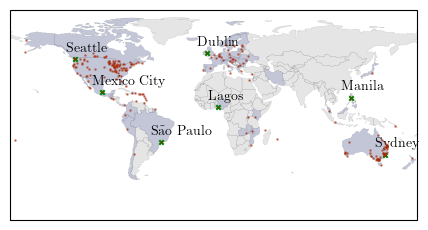

In [420]:
plot_probe_map(ndt7_df, city_df, interesting_cities, figsize=(4.5, 2.4), annotate_minimal=True, savefig="mlab_probecities_global_highlighted.pdf")

### KDE Clustering

In [421]:
import numpy as np
import seaborn as sns

def kde_region(region, 
               bw_width=0.2,
               bw_adjust=0.5,
               linktype="both",
               xlabel="Median Throughput [Mbps]",
               col="a_MedianThroughputMbps",
               xlim=None,
               xticks_args=(np.arange(0, 320, 20), [str(tick) if (i)%5==0 and i>-1else "" for i, tick in enumerate(np.arange(0, 320, 20))]),
               figsize=(3.37, 2),
               dffilter = (lambda df: df),
               legendloc="upper right"
              ):
    fig, ax = plt.subplots(figsize=figsize)
    region_cities = {
        "au": [
                "Sydney",
                "Perth",
                "Noojee",
                "Kellevie",
                "Bororen"
        ],
        "eu": [
                "Dublin",
                "London",
                "Berlin",
                "Paris",
                "Rome"
        ],
        "sa": [
                "São Paulo",
                "Santiago",
                "Bogotá",
                "Lima"
        ],
        "na": [
                "Seattle",
                "Denver",
                "Dallas",
                "New York",
                "Los Angeles"
        ],
        "global": [
                "Mexico City",
                "São Paulo",
                "Seattle",
                "Sydney",
                "Dublin",
                "Lagos",
                "Manila"
        ]
    }
    interesting_cities = region_cities[region]
    interesting_cities = sorted(interesting_cities)

    city_colors = {city: cols[i % len(cols)] for i, city in enumerate(interesting_cities)}
    lstyles = {city: lstyle_array[i % len(lstyle_array)] for i, city in enumerate(interesting_cities)}

    df = city_df[ 
        city_df["client_Geo_City"].isin(interesting_cities)
    ]
    #df = df[df["a_MedianThroughputMbps"] > 0]
    from unidecode import unidecode
    df = df[(df["client_Geo_City"].map(unidecode) == df["server_Geo_City"]) | (df["client_Geo_CountryCode"].map(unidecode) == df["server_Geo_CountryCode"].map(unidecode))]
    #df = df[(df["client_Geo_City"].map(unidecode) == df["server_Geo_City"])]
    if linktype == "both":
        pass
    elif linktype == "up":
        df = df[df["isDownload"] == False]
    else:
        df = df[df["isDownload"] == True]
    df = dffilter(df)
    #print(df)
    #sns.kdeplot(city_df["a_MedianThroughputMbps"], bw_method=0.5, ax=ax, label="KDE globally")

    #axs[0].hist(region_filters["AU"](city_df)["a_MedianThroughputMbps"], bins = 1000, label="AU")
    for city in interesting_cities:
        #print(city)
        sns.kdeplot(df[df["client_Geo_City"] == city][col], ax=ax, label=city, linestyle=lstyles[city], color=city_colors[city], bw_adjust=bw_adjust)
    #sns.kdeplot(region_filters["SA"](city_df)["a_MedianThroughputMbps"], bw_method=0.2, ax=axs[1], label="SA")
    #sns.kdeplot(region_filters["NA"](city_df)["a_MedianThroughputMbps"], bw_method=0.2, ax=axs[2], label="NA")
    #sns.kdeplot(region_filters["EU"](city_df)["a_MedianThroughputMbps"], bw_method=0.2, ax=axs[3], label="EU")
    #sns.kdeplot(region_filters["SA"](city_df)["a_MedianThroughputMbps"], bw_method=0.5, ax=ax, label="SA", bw_adjust=.05)
    #sns.kdeplot(region_filters["NA"](city_df)["a_MedianThroughputMbps"], bw_method=0.5, ax=ax, label="NA", bw_adjust=.05)
    #sns.kdeplot(region_filters["EU"](city_df)["a_MedianThroughputMbps"], bw_method=0.5, ax=ax, label="EU", bw_adjust=.05)

    # Setting axis labels
    ax.set_xlabel(xlabel)
    #ax.set_ylabel("Percentile")

    if xlim:
        ax.set_xlim(xlim)
    if xticks_args:
        ax.set_xticks(*xticks_args)
    ax.xaxis.get_major_formatter()._usetex = False
    ax.yaxis.get_major_formatter()._usetex = False
    #ax.xaxis.set_tick_params(rotation=15)

    ax.legend(loc=legendloc, fontsize="small", ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
              columnspacing=0.5, handletextpad=0.3, fancybox=False)
    plt.grid(True, axis='y', linestyle='-', alpha=0.7, linewidth=0.5)

    fig.tight_layout()
    plt.savefig("figures/mlab_kde_{}_{}_{}.pdf".format(col, region, linktype), bbox_inches = "tight", pad_inches = 0)
    plt.show()


Goodput Median:


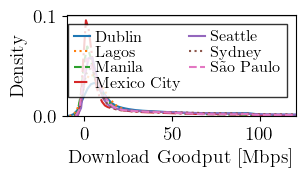

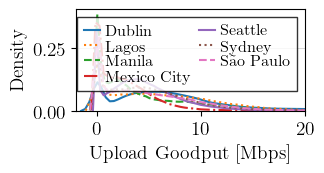

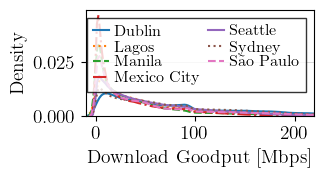

Goodput Mean:


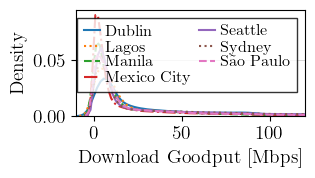

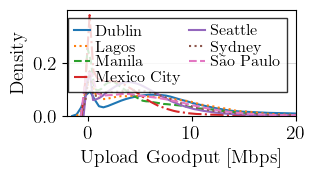

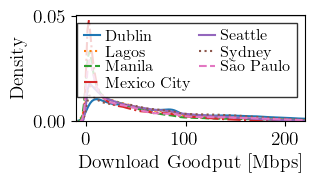

Mean Throughput given by Mlab:


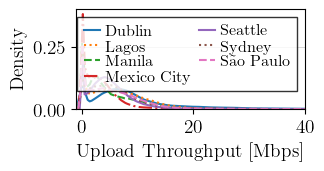

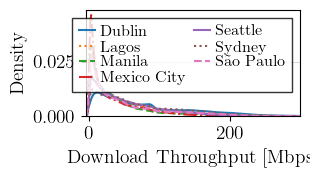

In [406]:
print("Goodput Median:")
kde_region("global", linktype="both", xlabel="Download Goodput [Mbps]", xlim=(-10, 120), col="GoodputMedian", xticks_args=())
kde_region("global", linktype="up",   xlabel="Upload Goodput [Mbps]", xlim=(-2, 20), xticks_args=(), col="GoodputMedian")
kde_region("global", linktype="down", xlabel="Download Goodput [Mbps]", xlim=(-10, 220), col="GoodputMedian", xticks_args=())

print("Goodput Mean:")
kde_region("global", linktype="both", xlabel="Download Goodput [Mbps]", xlim=(-10, 120), col="GoodputMean", xticks_args=())
kde_region("global", linktype="up",   xlabel="Upload Goodput [Mbps]", xlim=(-2, 20), col="GoodputMean", xticks_args=())
kde_region("global", linktype="down", xlabel="Download Goodput [Mbps]", xlim=(-10, 220), col="GoodputMean", xticks_args=())

print("Mean Throughput given by Mlab:")
kde_region("global", linktype="up", xlabel="Upload Throughput [Mbps]", col="a_MeanThroughputMbps", xlim=(-1, 40), xticks_args=())
kde_region("global", linktype="down", xlabel="Download Throughput [Mbps]", col="a_MeanThroughputMbps", xlim=(-5, 300), xticks_args=())

no filter


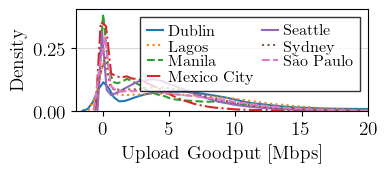

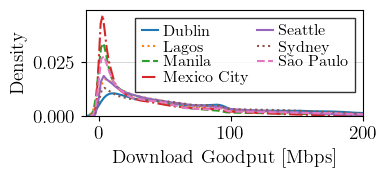

In [407]:
print("no filter")

kde_region("global",
               linktype="up",
               xlabel="Upload Goodput [Mbps]",
               xlim=(-2, 20),
               xticks_args=(),
               col="GoodputMedian",
               figsize=(4, 2)
          )
kde_region("global",
               linktype="down",
               xlabel="Download Goodput [Mbps]",
               xlim=(-10, 200),
               col="GoodputMedian",
               xticks_args=(),
               figsize=(4, 2)
          )

filter Goodput > 1


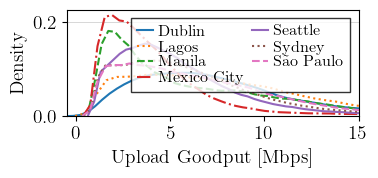

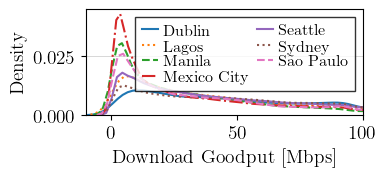

In [408]:
print("filter Goodput > 1")

kde_region("global",
               linktype="up",
               xlabel="Upload Goodput [Mbps]",
               xlim=(-0.5, 15),
               xticks_args=(),
               col="GoodputMedian",
               figsize=(4, 2),
               dffilter = (lambda ddf: ddf[ddf["GoodputMedian"] > 1])
          )
kde_region("global",
               linktype="down",
               xlabel="Download Goodput [Mbps]",
               xlim=(-10, 100),
               col="GoodputMedian",
               xticks_args=(),
               figsize=(4, 2),
               dffilter = (lambda ddf: ddf[ddf["GoodputMedian"] > 1])
          )

filter Goodput > 5


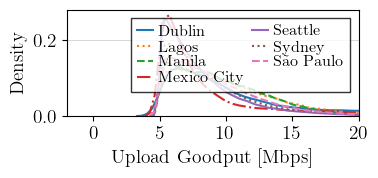

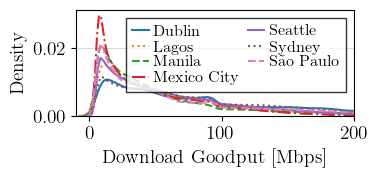

In [409]:
print("filter Goodput > 5")

kde_region("global",
               linktype="up",
               xlabel="Upload Goodput [Mbps]",
               xlim=(-2, 20),
               xticks_args=(),
               col="GoodputMedian",
               figsize=(4, 2),
               dffilter = (lambda ddf: ddf[ddf["GoodputMedian"] > 5])
          )
kde_region("global",
               linktype="down",
               xlabel="Download Goodput [Mbps]",
               xlim=(-10, 200),
               col="GoodputMedian",
               xticks_args=(),
               figsize=(4, 2),
               dffilter = (lambda ddf: ddf[ddf["GoodputMedian"] > 5])
          )

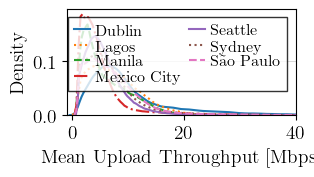

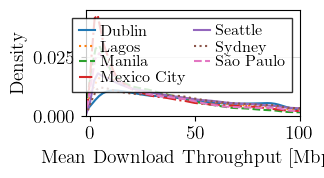

In [410]:
#kde_region("global", xlabel="Median Throughput [Mbps]", xlim=(-5, 200), figsize=(4.5, 2))
#kde_region("global", linktype="up", xlabel="Median Upload Throughput [Mbps]", xlim=(0.75, 1.8), xticks_args=(), figsize=(4.5, 2),
#                      dffilter = (lambda ddf: ddf[ddf["a_MedianThroughputMbps"] > 1.0]), legendloc="upper left")
#kde_region("global", linktype="down", xlabel="Median Download Throughput [Mbps]", xlim=(-5, 150), figsize=(4.5, 2), xticks_args=())

kde_region("global", 
               linktype="up",
               xlabel="Mean Upload Throughput [Mbps]", 
               col="a_MeanThroughputMbps",
               xlim=(-1, 40),
               xticks_args=(),
               dffilter = (lambda ddf: ddf[ddf["a_MeanThroughputMbps"] > 1.0]))
kde_region("global", 
                linktype="down",
               xlabel="Mean Download Throughput [Mbps]",
               col="a_MeanThroughputMbps",
               xlim=(-2, 100),
               xticks_args=(),
               dffilter = (lambda ddf: ddf[ddf["a_MeanThroughputMbps"] > 1.0]))

### CDF Analysis

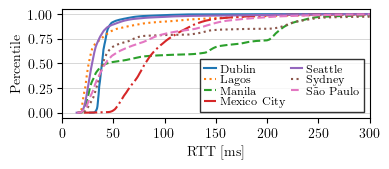

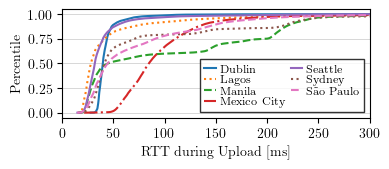

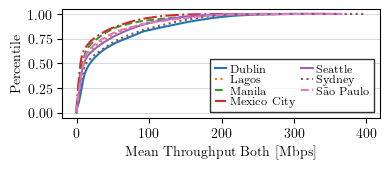

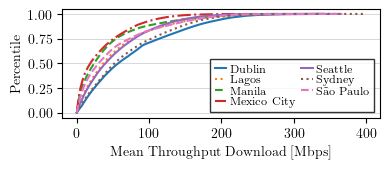

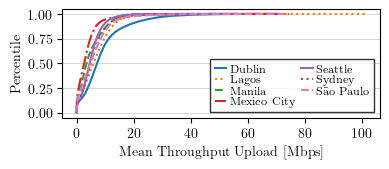

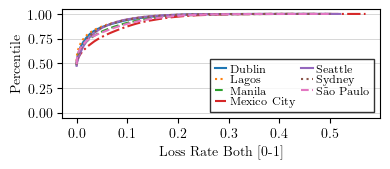

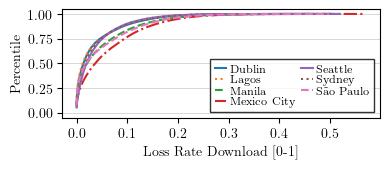

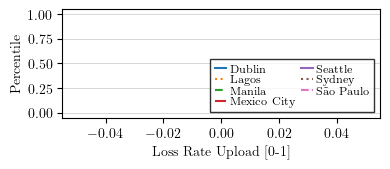

In [422]:
matplotlib.rcParams.update({"font.size": 10})
plot_cdf(down_df, interesting_cities, "a_MinRTT", "RTT [ms]", 
             figsize=(4, 1.8), xlim=(0, 300), city_colors=city_colors, lstyles=lstyles, savefig="mlab_cdf_minrtt_globalcities.pdf")

plot_cdf(up_df, interesting_cities, "a_MinRTT", "RTT during Upload [ms]", 
             figsize=(4, 1.8), xlim=(0, 300), city_colors=city_colors, lstyles=lstyles)

plot_cdf(df, interesting_cities, "a_MeanThroughputMbps", "Mean Throughput Both [Mbps]", 
             figsize=(4, 1.8), city_colors=city_colors, lstyles=lstyles)

plot_cdf(down_df, interesting_cities, "a_MeanThroughputMbps", "Mean Throughput Download [Mbps]", 
             figsize=(4, 1.8), city_colors=city_colors, lstyles=lstyles, savefig="mlab_cdf_meanthroughput-down_globalcities.pdf")
plot_cdf(up_df, interesting_cities, "a_MeanThroughputMbps", "Mean Throughput Upload [Mbps]", 
             figsize=(4, 1.8), city_colors=city_colors, lstyles=lstyles, savefig="mlab_cdf_meanthroughput-up_globalcities.pdf")

#plot_cdf(down_df, interesting_cities, "a_MedianThroughputMbps", "Median Throughput Download [Mbps]", 
#             figsize=(4, 2), city_colors=city_colors, lstyles=lstyles, savefig="mlab_cdf_medianthroughput-down_globalcities.pdf")
#plot_cdf(up_df, interesting_cities, "a_MedianThroughputMbps", "Median Throughput Upload [Mbps]", 
#             figsize=(4, 2), city_colors=city_colors, lstyles=lstyles, xlim=(0, 0.1), savefig="mlab_cdf_medianthroughput-up_globalcities.pdf")

#plot_cdf(df, interesting_cities, "a_MedianThroughputMbps", "Throughput [Mbps]", 
#             figsize=(3.37, 2), city_colors=city_colors, lstyles=lstyles, savefig="mlab_cdf_medianthroughput_globalcities.pdf")
plot_cdf(df, interesting_cities, "a_LossRate", "Loss Rate Both [0-1]", 
             figsize=(4, 1.8), city_colors=city_colors, lstyles=lstyles)
plot_cdf(down_df, interesting_cities, "a_LossRate", "Loss Rate Download [0-1]", 
             figsize=(4, 1.8), city_colors=city_colors, lstyles=lstyles, savefig="mlab_cdf_lossrate-down_globalcities.pdf")
plot_cdf(up_df, interesting_cities, "a_LossRate", "Loss Rate Upload [0-1]", 
             figsize=(4, 1.8), city_colors=city_colors, lstyles=lstyles)

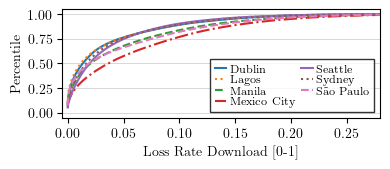

In [423]:
matplotlib.rcParams.update({"font.size": 10})
plot_cdf(down_df, interesting_cities, "a_LossRate", "Loss Rate Download [0-1]", xlim=(-0.005, 0.28),
             figsize=(4, 1.8), city_colors=city_colors, lstyles=lstyles, savefig="mlab_cdf_lossrate-down_globalcities.pdf")

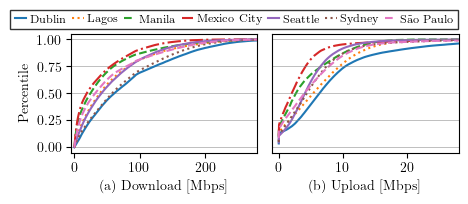

In [435]:
#plot_cdf(df, interesting_cities, "GoodputMedian", "Goodput [Mbps]", 
#             figsize=(4, 1.7), city_colors=city_colors, xlim=(-5, 300), lstyles=lstyles, savefig="mlab_cdf_mediangoodput-both_globalcities.pdf")

fig, axs = plt.subplots(1, 2, figsize=(4.7, 1.9))

plot_cdf(down_df, interesting_cities, "GoodputMedian", "(a) Download [Mbps]",
                  show=False, ax=axs[0], skiplegend=True,
             figsize=(4, 1.7), city_colors=city_colors, xlim=(-5, 280), lstyles=lstyles)

plot_cdf(up_df,  interesting_cities, "GoodputMedian", "(b) Upload [Mbps]", 
                show=False, ax=axs[1], skiplegend=False,
             figsize=(4, 1.7), city_colors=city_colors, xlim=(-1, 28), lstyles=lstyles)
axs[1].set_ylabel("")
axs[1].set_yticks([])
axs[0].grid(True, axis='y', linestyle='-', alpha=0.7, linewidth=0.5, color="grey")
axs[1].axhline(0.00, linestyle='-', alpha=0.7, linewidth=0.5, color="grey")
axs[1].axhline(0.25, linestyle='-', alpha=0.7, linewidth=0.5, color="grey")
axs[1].axhline(0.50, linestyle='-', alpha=0.7, linewidth=0.5, color="grey")
axs[1].axhline(0.75, linestyle='-', alpha=0.7, linewidth=0.5, color="grey")
axs[1].axhline(1.00, linestyle='-', alpha=0.7, linewidth=0.5, color="grey")

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',
          fontsize="small", ncol=7, edgecolor="k", handlelength=1, labelspacing=0.06, bbox_to_anchor=(0.49, 1.08),
                  columnspacing=0.5, handletextpad=0.3, fancybox=False)

axs[1].get_legend().remove()

fig.tight_layout()
plt.savefig(os.path.join("figures", "mlab_cdf_mediangoodput-both_globalcities.pdf"), bbox_inches="tight", pad_inches=0)
plt.savefig(os.path.join("figures", "mlab_cdf_mediangoodput-both_globalcities.svg"), bbox_inches="tight", pad_inches=0)
plt.show()

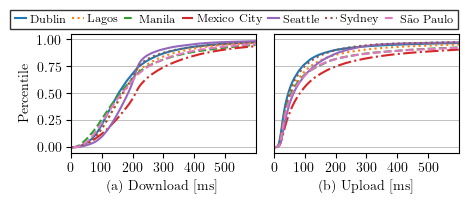

In [436]:
#plot_cdf(df, interesting_cities, "GoodputMedian", "Goodput [Mbps]", 
#             figsize=(4, 1.7), city_colors=city_colors, xlim=(-5, 300), lstyles=lstyles, savefig="mlab_cdf_mediangoodput-both_globalcities.pdf")

fig, axs = plt.subplots(1, 2, figsize=(4.7, 1.9))

plot_cdf(down_df, interesting_cities, "a_DiffRTT", "(a) Download [ms]",
                  show=False, ax=axs[0], skiplegend=True,
             figsize=(4, 1.7), city_colors=city_colors, xlim=(0, 600), lstyles=lstyles)

plot_cdf(up_df,  interesting_cities, "a_DiffRTT", "(b) Upload [ms]", 
                show=False, ax=axs[1], skiplegend=False,
             figsize=(4, 1.7), city_colors=city_colors, xlim=(0, 600), lstyles=lstyles)
axs[1].set_ylabel("")
axs[1].set_yticks([])
axs[0].grid(True, axis='y', linestyle='-', alpha=0.7, linewidth=0.5, color="grey")
axs[1].axhline(0.00, linestyle='-', alpha=0.7, linewidth=0.5, color="grey")
axs[1].axhline(0.25, linestyle='-', alpha=0.7, linewidth=0.5, color="grey")
axs[1].axhline(0.50, linestyle='-', alpha=0.7, linewidth=0.5, color="grey")
axs[1].axhline(0.75, linestyle='-', alpha=0.7, linewidth=0.5, color="grey")
axs[1].axhline(1.00, linestyle='-', alpha=0.7, linewidth=0.5, color="grey")

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',
          fontsize="small", ncol=7, edgecolor="k", handlelength=1, labelspacing=0.06, bbox_to_anchor=(0.49, 1.08),
                  columnspacing=0.5, handletextpad=0.3, fancybox=False)

axs[1].get_legend().remove()

axs[0].set_xticks(np.arange(0, 600, 100))
axs[1].set_xticks(np.arange(0, 600, 100))

fig.tight_layout()
plt.savefig(os.path.join("figures", "mlab_cdf_diffrtt-both_globalcities.pdf"), bbox_inches="tight", pad_inches=0)
plt.savefig(os.path.join("figures", "mlab_cdf_diffrtt-both_globalcities.svg"), bbox_inches="tight", pad_inches=0)
plt.show()

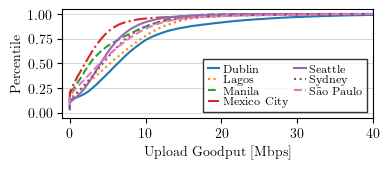

In [432]:
plot_cdf(up_df, interesting_cities, "GoodputMedian", "Upload Goodput [Mbps]", 
             figsize=(4, 1.8), city_colors=city_colors, xlim=(-1, 40), lstyles=lstyles, savefig="mlab_cdf_mediangoodput-up_globalcities.pdf")

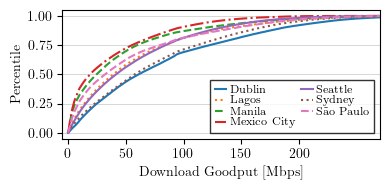

In [433]:
plot_cdf(down_df, 
         interesting_cities, "GoodputMedian", "Download Goodput [Mbps]", 
         figsize=(4, 2), city_colors=city_colors, lstyles=lstyles, savefig="mlab_cdf_mediangoodput-down_globalcities.pdf",
         xticks=np.arange(0, 250, 50),
        xlim=(-5, 270))

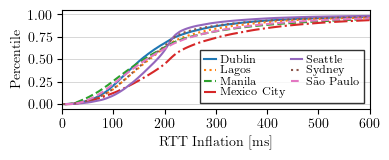

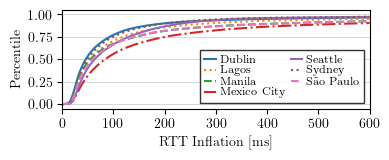

In [434]:
plot_cdf(down_df, interesting_cities, "a_DiffRTT", "RTT Inflation [ms]", 
             figsize=(4, 1.7), xlim=(0, 600), city_colors=city_colors, lstyles=lstyles, savefig="mlab_cdf_diffrtt_down_globalcities.pdf", legendloc="lower right")

plot_cdf(up_df, interesting_cities, "a_DiffRTT", "RTT Inflation [ms]", 
             figsize=(4, 1.7), xlim=(0, 600), city_colors=city_colors, lstyles=lstyles, savefig="mlab_cdf_diffrtt_up_globalcities.pdf")

In [418]:
print("Download max lossrate {}; Downlad min lossrate {};".format(down_df["a_LossRate"].max(), down_df["a_LossRate"].min()))
print("Upload max lossrate {}; Upload min lossrate {};".format(up_df["a_LossRate"].max(), up_df["a_LossRate"].min()))

Download max lossrate 0.5706079230905778; Downlad min lossrate 0.0;
Upload max lossrate 0.0; Upload min lossrate 0.0;


In [265]:
# Kyiv filtered out because it would be an interesting side-analysis

city_colors = {city: cols[i % len(cols)] for i, city in enumerate(interesting_cities)}

lstyles = {city: lstyle_array[i % len(lstyle_array)] for i, city in enumerate(interesting_cities)}

trace_tput_df = pd.read_csv("data/traceroute_join_countrycity.csv")

def apply_str_to_list(s: str):
    s = s[1:-1]
    l = [float(num.strip()) for num in s.split(",")]
    return l

def apply_extract_median(arr: list):
    return arr[len(arr)//2]

trace_tput_df["stl_rtt_fraction"] = trace_tput_df["stl_rtt_fraction"].apply(apply_str_to_list)
trace_tput_df["stl_rtt"] = trace_tput_df["stl_rtt"].apply(apply_str_to_list)
trace_tput_df["median_stl_rtt"] = trace_tput_df["stl_rtt"].apply(apply_extract_median)
#trace_tput_df = trace_tput_df[trace_tput_df["cityC"].isin(interesting_cities)]
trace_tput_df.sort_values("cnt", ascending=False)


,cnt,countryC,cityC,dist_km,stl_rtt_fraction,stl_rtt,min_rtt,trace_rtt,num_hops,tput_mbps,dl_mbps,ul_mbps,loss_rate,median_stl_rtt
175,1921102,US,Seattle,17.346849,"[0.01, 42.8, 84.62, 92.28, 97.6, 97.83, 97.97,...","[0.0020000000000024443, 18.712, 19.544, 20.163...",30.665,0.295,5,9.737493,36.397503,4.527121,0.000413,30.149
117,1899373,US,Chicago,24.747725,"[0.01, 36.08, 53.96, 64.29, 78.46, 91.86, 92.6...","[0.0030000000000001137, 14.248999999999999, 18...",34.302,0.338,6,10.065709,36.907954,4.731187,0.000751,33.007
111,1653781,US,Atlanta,23.515289,"[0.0, 64.54, 87.05, 98.55, 98.65, 98.71, 98.75...","[0.0009999999999976694, 19.25, 20.759, 21.715,...",32.718,0.261,5,8.249735,28.576786,3.887207,0.000791,32.262
124,1628998,US,Dallas,26.124749,"[0.01, 93.97, 95.29, 96.31, 96.8, 97.08, 97.27...","[0.003999999999997783, 19.28, 19.9749999999999...",31.724,0.252,5,8.475519,29.771688,3.851679,0.000851,31.296
71,1605226,CA,Toronto,16.952010,"[0.02, 45.67, 52.14, 54.39, 55.81, 56.79, 57.6...","[0.006000000000000227, 18.649, 20.397, 21.4350...",49.712,14.694,6,10.539227,42.076077,4.625994,0.000437,34.463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,2,US,Horseshoe Bend,615.998991,"[98.9, 98.9, 98.9, 98.9, 98.9, 98.9, 98.9, 98....","[28.387999999999998, 28.387999999999998, 28.38...",28.705,0.317,6,3.396789,23.241950,3.396789,0.000000,28.388
167,2,US,Nome,5719.480255,"[51.6, 51.6, 51.6, 51.6, 51.6, 51.6, 51.6, 51....","[49.018, 49.018, 49.018, 49.018, 49.018, 49.01...",95.000,45.982,11,0.088384,171.631295,0.088384,0.000000,49.018
174,1,US,Rixeyville,446.686794,"[20.07, 20.07, 20.07, 20.07, 20.07, 20.07, 20....","[10.978000000000002, 10.978000000000002, 10.97...",54.688,43.710,6,23.070508,23.070508,NaN,0.001295,10.978
37,1,AU,Orangeville,54.229115,"[9.81, 9.81, 9.81, 9.81, 9.81, 9.81, 9.81, 9.8...","[22.52799999999999, 22.52799999999999, 22.5279...",229.641,207.113,7,25.524992,25.524992,NaN,0.055360,22.528


In [255]:
def plot_cdf_(df, dataCol, cities, xlabel,
                 ax=None,
                 fig=None,
                 show=True,
                 figsize=(7, 4),
                 savefig="",
                 title="CDF",
                 city_colors={},
                 lstyles={},
                 condition=True,
                 skiplegend=False,
                 figures_path="figures", xlim=None, legendsettings={}, legendloc="lower right", xticks=None, xticklabels=None, ylabel="Percentile", stripylabels=False):
    if ax==None:
        fig, ax = plt.subplots(figsize=figsize)
    for city in cities:
        #  & (df["a_MinRTT"] < 600)
        xs = df[(df["cityC"] == city) & (condition)][dataCol].iloc[0]
        ys = [i / 100 for i in range(101)]
        ax.plot(xs, ys, label=city, color=city_colors[city], linestyle=lstyles[city])

    if xlim is not None:
        ax.set_xlim(*xlim)
    if xticks is not None:
        ax.set_xticks(xticks)
    if xticklabels is not None:
        ax.set_xticks(xticklabels)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if stripylabels:
        ax.set_yticks(np.arange(0, 1.25, 0.25), labels=[""]*len(np.arange(0, 1.25, 0.25)))
    else:
        ax.set_yticks(np.arange(0, 1.25, 0.25))
    ax.xaxis.get_major_formatter()._usetex = False
    ax.yaxis.get_major_formatter()._usetex = False

    handles, labels = plt.gca().get_legend_handles_labels()
    sorted_hl = sorted(zip(handles, labels), key=(lambda t: t[1]), reverse=False)
    if not skiplegend:
        ax.legend([t[0] for t in sorted_hl],
                  [t[1] for t in sorted_hl], loc=legendloc, fontsize="small", ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
                  columnspacing=0.5, handletextpad=0.3, fancybox=False)
    ax.grid(True, axis='y', linestyle='-', alpha=0.7, linewidth=0.5)
    
    ax.set_ylim((-0.05, 1.05))

    #plt.title(title)
    if fig != None:
        fig.tight_layout()
    if(savefig != ""):
        if ".pdf" in savefig:
            svg_savefig = savefig.replace(".pdf", ".svg")
            plt.savefig(os.path.join(figures_path, svg_savefig), bbox_inches="tight", pad_inches=0)
        plt.savefig(os.path.join(figures_path, savefig), bbox_inches="tight", pad_inches=0)
    if show:
        plt.show()

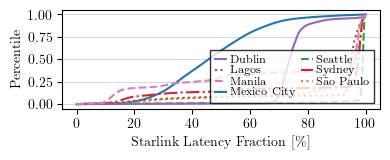

In [258]:
plot_cdf_(trace_tput_df, "stl_rtt_fraction", interesting_cities, "Starlink Latency Fraction [\%]", 
             figsize=(4, 1.7), city_colors=city_colors, lstyles=lstyles)

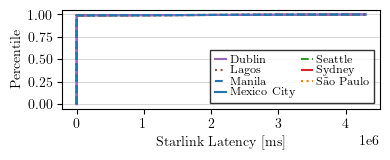

In [344]:
plot_cdf_(trace_tput_df, "stl_rtt", interesting_cities, "Starlink Latency [ms]", 
             figsize=(4, 1.7), city_colors=city_colors, lstyles=lstyles)

NameError: name 'country_codes' is not defined

### Over entire Time Range

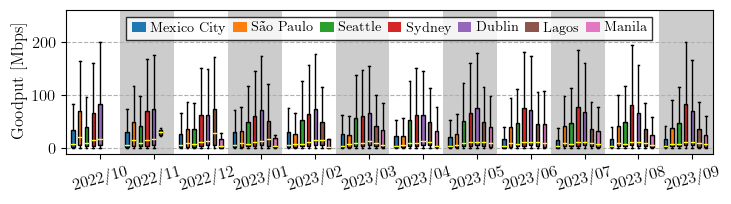

In [212]:
matplotlib.rcParams.update({"font.size": 12})
months_array = df[["a_TestMonth"]].drop_duplicates().sort_values("a_TestMonth")["a_TestMonth"]
datetime_array = [datetime.fromisoformat(str(dt_str)) for dt_str in months_array]
data_array = [
    {c: df[(df["client_Geo_City"] == c) & (df["a_TestMonth"] == month)]["GoodputMedian"]
         for c in interesting_cities} for month in months_array
]

# Mean throughput
plot_boxplot_progression(datetime_array[-12:], data_array[-12:],
                            figsize=(7.5, 2.2),
                             ylim=(-10, 260),
                            figures_path="figures",
                             nlegendcols=7,
                             savefig="mlab_throughput_globalcities_2022-10_to_2023-09.pdf", ylabel="Goodput [Mbps]",
                             orientation="upper center"
                        )

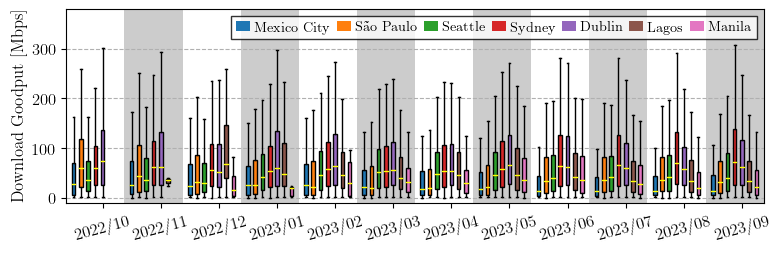

In [213]:
months_array = df[["a_TestMonth"]].drop_duplicates().sort_values("a_TestMonth")["a_TestMonth"]
datetime_array = [datetime.fromisoformat(str(dt_str)) for dt_str in months_array]
data_array = [
    {c: down_df[(down_df["client_Geo_City"] == c) & (down_df["a_TestMonth"] == month)]["GoodputMedian"]
         for c in interesting_cities} for month in months_array
]

# Mean throughput
plot_boxplot_progression(datetime_array[-12:], data_array[-12:],
                            figsize=(8, 2.7),
                            figures_path="figures",
                         ylim=(-10, 380),
                             nlegendcols=7,
                             savefig="mlab_goodputmedian-down_globalcities_2022-10_to_2023-09.pdf", ylabel="Download Goodput [Mbps]",
                             orientation="upper right"
                        )

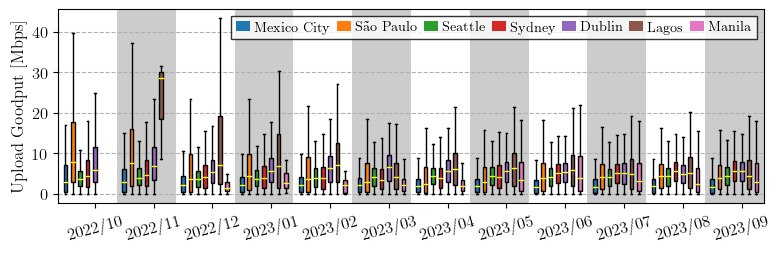

In [214]:
months_array = df[["a_TestMonth"]].drop_duplicates().sort_values("a_TestMonth")["a_TestMonth"]
datetime_array = [datetime.fromisoformat(str(dt_str)) for dt_str in months_array]
data_array = [
    {c: up_df[(up_df["client_Geo_City"] == c) & (up_df["a_TestMonth"] == month)]["GoodputMedian"]
         for c in interesting_cities} for month in months_array
]

# Mean throughput
plot_boxplot_progression(datetime_array[-12:], data_array[-12:],
                            figsize=(8, 2.7),
                            figures_path="figures",
                             nlegendcols=7,
                             savefig="mlab_goodputmedian-up_globalcities_2022-10_to_2023-09.pdf", ylabel="Upload Goodput [Mbps]",
                             orientation="upper right"
                        )

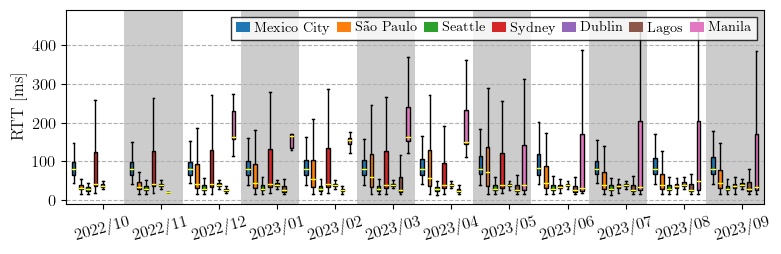

In [215]:
months_array = df[["a_TestMonth"]].drop_duplicates().sort_values("a_TestMonth")["a_TestMonth"]
datetime_array = [datetime.fromisoformat(str(dt_str)) for dt_str in months_array]
data_array = [
    {c: down_df[(down_df["client_Geo_City"] == c) & (down_df["a_TestMonth"] == month)]["a_MinRTT"]
         for c in interesting_cities} for month in months_array
]

# MinRTT
plot_boxplot_progression(datetime_array[-12:], data_array[-12:],
                            figsize=(8, 2.7),
                            figures_path="figures",
                             nlegendcols=7,
                             savefig="mlab_minrtt_globalcities_2022-10_to_2023-09.pdf", ylabel="RTT [ms]",
                             orientation="upper right"
                        )

In [73]:
for d, m in zip(data_array, months_array):
    print("================")
    print(m)
    print(d.keys())
    print([len(arr) for arr in d.values()])
    print("================")

2021-06-01 00:00:00
dict_keys(['Mexico City', 'São Paulo', 'Seattle', 'Sydney', 'Dublin', 'Lagos', 'Manila'])
[0, 0, 2, 0, 0, 0, 0]
2021-07-01 00:00:00
dict_keys(['Mexico City', 'São Paulo', 'Seattle', 'Sydney', 'Dublin', 'Lagos', 'Manila'])
[0, 0, 12, 0, 0, 0, 0]
2021-08-01 00:00:00
dict_keys(['Mexico City', 'São Paulo', 'Seattle', 'Sydney', 'Dublin', 'Lagos', 'Manila'])
[0, 0, 13, 0, 0, 0, 0]
2021-09-01 00:00:00
dict_keys(['Mexico City', 'São Paulo', 'Seattle', 'Sydney', 'Dublin', 'Lagos', 'Manila'])
[0, 0, 96, 0, 0, 0, 0]
2021-10-01 00:00:00
dict_keys(['Mexico City', 'São Paulo', 'Seattle', 'Sydney', 'Dublin', 'Lagos', 'Manila'])
[0, 0, 1485, 0, 0, 0, 0]
2021-11-01 00:00:00
dict_keys(['Mexico City', 'São Paulo', 'Seattle', 'Sydney', 'Dublin', 'Lagos', 'Manila'])
[0, 0, 5658, 0, 0, 0, 0]
2021-12-01 00:00:00
dict_keys(['Mexico City', 'São Paulo', 'Seattle', 'Sydney', 'Dublin', 'Lagos', 'Manila'])
[0, 6, 8725, 0, 0, 0, 0]
2022-01-01 00:00:00
dict_keys(['Mexico City', 'São Paulo', 'Seat

## Kernel Density Estimation Function

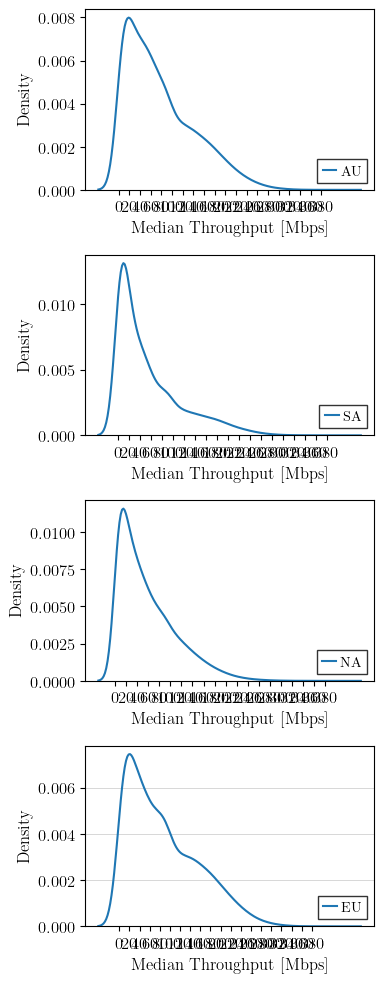

In [75]:
import numpy as np
import seaborn as sns

fig, axs = plt.subplots(4, figsize=(4, 10))

# Create CDF plot
#sns.kdeplot(city_df["a_MedianThroughputMbps"], bw_method=0.5, ax=ax, label="KDE globally")

#axs[0].hist(region_filters["AU"](city_df)["a_MedianThroughputMbps"], bins = 1000, label="AU")
sns.kdeplot(region_filters["AU"](city_df)["ThroughputMedian"], bw_method=0.2, ax=axs[0], label="AU")
sns.kdeplot(region_filters["SA"](city_df)["ThroughputMedian"], bw_method=0.2, ax=axs[1], label="SA")
sns.kdeplot(region_filters["NA"](city_df)["ThroughputMedian"], bw_method=0.2, ax=axs[2], label="NA")
sns.kdeplot(region_filters["EU"](city_df)["ThroughputMedian"], bw_method=0.2, ax=axs[3], label="EU")
#sns.kdeplot(region_filters["SA"](city_df)["a_MedianThroughputMbps"], bw_method=0.5, ax=ax, label="SA", bw_adjust=.05)
#sns.kdeplot(region_filters["NA"](city_df)["a_MedianThroughputMbps"], bw_method=0.5, ax=ax, label="NA", bw_adjust=.05)
#sns.kdeplot(region_filters["EU"](city_df)["a_MedianThroughputMbps"], bw_method=0.5, ax=ax, label="EU", bw_adjust=.05)

# Setting axis labels
for ax in axs:
    ax.set_xlabel("Median Throughput [Mbps]")
    #ax.set_ylabel("Percentile")

    ax.set_xticks(np.arange(0, 400, 20))
    ax.xaxis.get_major_formatter()._usetex = False
    ax.yaxis.get_major_formatter()._usetex = False

    ax.legend(loc="lower right", fontsize="small", ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
              columnspacing=0.5, handletextpad=0.3, fancybox=False)
plt.grid(True, axis='y', linestyle='-', alpha=0.7, linewidth=0.5)

fig.tight_layout()
# plt.savefig("example.pdf", bbox_inches = "tight", pad_inches = 0)
plt.show()


## List of Countries with Probes going into same country

In [76]:
# Queried from Mlab
same_country_countries = """
CountryName
Peru
Australia
Belgium
Ireland
Czechia
Germany
Philippines
Italy
Kenya
France
Greece
Nigeria
United States
Mozambique
Mexico
Spain
Bulgaria
Canada
Indonesia
Slovenia
Brazil
Sweden
Poland
Portugal
Chile
United Kingdom
Netherlands
Norway
New Zealand
Japan
Colombia
"""
same_country_countries = same_country_countries.split("\n")[2:-1]

In [77]:
same_country_countries

['Peru',
 'Australia',
 'Belgium',
 'Ireland',
 'Czechia',
 'Germany',
 'Philippines',
 'Italy',
 'Kenya',
 'France',
 'Greece',
 'Nigeria',
 'United States',
 'Mozambique',
 'Mexico',
 'Spain',
 'Bulgaria',
 'Canada',
 'Indonesia',
 'Slovenia',
 'Brazil',
 'Sweden',
 'Poland',
 'Portugal',
 'Chile',
 'United Kingdom',
 'Netherlands',
 'Norway',
 'New Zealand',
 'Japan',
 'Colombia']

## Specialized Investigation

### Philippines to Japan vs. Philippines to Philippines

In [326]:
# Philippines->Japan & Philippines->Philippines
ph_df = city_df[(city_df["client_Geo_CountryCode"] == "PH") & ((city_df["server_Geo_CountryCode"] == "JP") | (city_df["server_Geo_CountryCode"] == "PH"))]

In [331]:
ph_df_premay = ph_df[ph_df["date"] <= "2023-05-01"]
ph_df_postmay = ph_df[ph_df["date"] > "2023-05-01"]

Month: 2022-12-01 00:00:00; Conn: PH-PH; Count: 44
Month: 2022-12-01 00:00:00; Conn: PH-JP; Count: 0
Month: 2023-01-01 00:00:00; Conn: PH-PH; Count: 17
Month: 2023-01-01 00:00:00; Conn: PH-JP; Count: 0
Month: 2023-02-01 00:00:00; Conn: PH-PH; Count: 16
Month: 2023-02-01 00:00:00; Conn: PH-JP; Count: 0
Month: 2023-03-01 00:00:00; Conn: PH-PH; Count: 6435
Month: 2023-03-01 00:00:00; Conn: PH-JP; Count: 10
Month: 2023-04-01 00:00:00; Conn: PH-PH; Count: 17140
Month: 2023-04-01 00:00:00; Conn: PH-JP; Count: 53
Month: 2023-05-01 00:00:00; Conn: PH-PH; Count: 13534
Month: 2023-05-01 00:00:00; Conn: PH-JP; Count: 14
Month: 2023-06-01 00:00:00; Conn: PH-PH; Count: 19166
Month: 2023-06-01 00:00:00; Conn: PH-JP; Count: 10
Month: 2023-07-01 00:00:00; Conn: PH-PH; Count: 28424
Month: 2023-07-01 00:00:00; Conn: PH-JP; Count: 14
Month: 2023-08-01 00:00:00; Conn: PH-PH; Count: 55105
Month: 2023-08-01 00:00:00; Conn: PH-JP; Count: 2
Month: 2023-09-01 00:00:00; Conn: PH-PH; Count: 54017
Month: 2023-09-

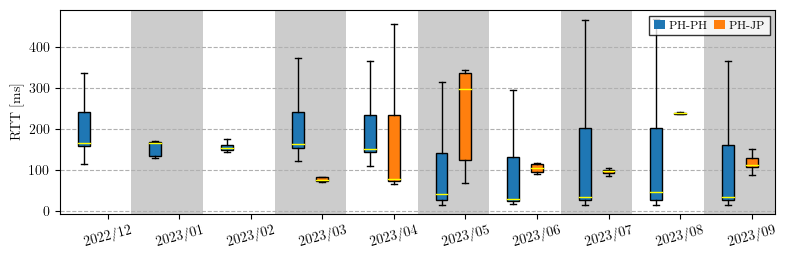

In [225]:
months_array = df[["a_TestMonth"]].drop_duplicates().sort_values("a_TestMonth")["a_TestMonth"]
datetime_array = [datetime.fromisoformat(str(dt_str)) for dt_str in months_array]
data_array = [
    {c: ph_df[(ph_df["server_Geo_CountryCode"] == c.split("-")[1]) & (ph_df["a_TestMonth"] == month)]["a_MinRTT"]
         for c in ["PH-PH", "PH-JP"]} for month in months_array
]

for month in months_array[-10:]:
    for c in ["PH-PH", "PH-JP"]:
        count = ph_df[(ph_df["server_Geo_CountryCode"] == c.split("-")[1]) & (ph_df["a_TestMonth"] == month)].shape[0]
        print(f"Month: {month}; Conn: {c}; Count: {count}")

# MinRTT
plot_boxplot_progression(datetime_array[-10:], data_array[-10:],
                            figsize=(8, 2.7),
                            figures_path="figures",
                             nlegendcols=7,
                             savefig="", ylabel="RTT [ms]",
                             orientation="upper right"
                        )

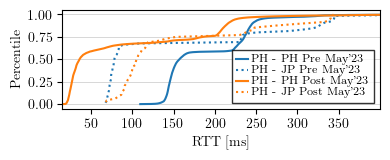

In [350]:
#def plot_cdf(df, cities, column, xlabel,

savefig=""
title="CDF"
city_colors={}
lstyles={}
condition=True
figures_path="figures"
xlim=None
legendsettings={}
legendloc="lower right"

matplotlib.rcParams.update({"font.size": 10})
fig, ax = plt.subplots(figsize=(4, 1.7))

# Philippines->PH Premay
xs = ph_df_premay[ph_df_premay["server_Geo_CountryCode"] == "PH"]["a_MinRTT"].values
xs = sorted(xs)
if len(xs) == 0:
    raise RuntimeError()
ys = np.arange(1, len(xs) + 1) / len(xs)
indices = []
current = xs[0]
for i, x in enumerate(xs): # only take max y value at each x value to smoothen out the graph
    if x != current:
        current = x
        indices.append(i - 1)
indices.append(len(ys) - 1)
xs = sorted(set(xs))
ys = [ys[i] for i in indices]
ax.plot(xs, ys, label="PH - PH Pre May'23", color=cols[0], linestyle=lstyle_array[0])

# Philippines->JP Premay
xs = ph_df_premay[ph_df_premay["server_Geo_CountryCode"] == "JP"]["a_MinRTT"].values
xs = sorted(xs)
if len(xs) == 0:
    raise RuntimeError()
ys = np.arange(1, len(xs) + 1) / len(xs)
indices = []
current = xs[0]
for i, x in enumerate(xs): # only take max y value at each x value to smoothen out the graph
    if x != current:
        current = x
        indices.append(i - 1)
indices.append(len(ys) - 1)
xs = sorted(set(xs))
ys = [ys[i] for i in indices]
ax.plot(xs, ys, label="PH - JP Pre May'23", color=cols[0], linestyle=lstyle_array[1])

# Philippines->PH Postmay
xs = ph_df_postmay[ph_df_postmay["server_Geo_CountryCode"] == "PH"]["a_MinRTT"].values
xs = sorted(xs)
if len(xs) == 0:
    raise RuntimeError()
ys = np.arange(1, len(xs) + 1) / len(xs)
indices = []
current = xs[0]
for i, x in enumerate(xs): # only take max y value at each x value to smoothen out the graph
    if x != current:
        current = x
        indices.append(i - 1)
indices.append(len(ys) - 1)
xs = sorted(set(xs))
ys = [ys[i] for i in indices]
ax.plot(xs, ys, label="PH - PH Post May'23", color=cols[1], linestyle=lstyle_array[0])

# Philippines->JP Postmay
xs = ph_df_postmay[ph_df_postmay["server_Geo_CountryCode"] == "JP"]["a_MinRTT"].values
xs = sorted(xs)
if len(xs) == 0:
    raise RuntimeError()
ys = np.arange(1, len(xs) + 1) / len(xs)
indices = []
current = xs[0]
for i, x in enumerate(xs): # only take max y value at each x value to smoothen out the graph
    if x != current:
        current = x
        indices.append(i - 1)
indices.append(len(ys) - 1)
xs = sorted(set(xs))
ys = [ys[i] for i in indices]
ax.plot(xs, ys, label="PH - JP Post May'23", color=cols[1], linestyle=lstyle_array[1])

ax.set_xlim((15, 400))
ax.set_xlabel("RTT [ms]")
ax.set_ylabel("Percentile")
ax.set_yticks(np.arange(0, 1.25, 0.25))
ax.set_xticks(np.arange(50, 400, 50))
ax.xaxis.get_major_formatter()._usetex = False
ax.yaxis.get_major_formatter()._usetex = False

ax.legend(loc=legendloc, fontsize="small", ncol=1, edgecolor="k", handlelength=1, labelspacing=0.06,
          columnspacing=0.5, handletextpad=0.3, fancybox=False)
plt.grid(True, axis='y', linestyle='-', alpha=0.7, linewidth=0.5)

#plt.title(title)
fig.tight_layout()
plt.savefig(os.path.join("figures", "mlab_cdf_rtt_phjp.pdf"), bbox_inches="tight", pad_inches=0)
plt.show()

### LossRate CDF of global cities in Starlink vs. MNO

In [81]:
df = pd.read_csv("data/mlab_starlink_data/mlab_cdf_cities_down.csv")
# Turn str of list into python list
df["lossrate_percentiles"] = df["lossrate_percentiles"].apply(eval)
df["minrtt_percentiles"] = df["minrtt_percentiles"].apply(eval)
df["down_queuedelay_percentiles"] = df["down_queuedelay_percentiles"].apply(eval)
samecity_df = df[df["ClientCountryCode"] == df["ServerCountryCode"]]
samecity_df = samecity_df[samecity_df["MeasurementCount"] > 1000]
#samecity_df = samecity_df[samecity_df[""] > 1000]

In [82]:
city_cc_df = samecity_df[samecity_df["Operator"] == "sl"][["ClientCity", "ClientCountryCode"]].drop_duplicates()
city_cc = [(row["ClientCity"], row["ClientCountryCode"]) for _, row in city_cc_df.iterrows()]

In [83]:
#city_cc = [
#        ("Mexico City", "MX"),
#        ("São Paulo", "BR"),
#        ("Seattle", "US"),
#        ("Sydney", "AU"),
#        ("Dublin", "IE"),
#        ("Lagos", "NG"),
#        ("Manila", "PH")
#]

#df = pd.read_csv("data/mlab_cdf_cities_down.csv")
# Turn str of list into python list
#df["lossrate_percentiles"] = df["lossrate_percentiles"].apply(eval)
#samecity_df = df[df["ClientCountryCode"] == df["ServerCountryCode"]]
for idx, (city, cc) in enumerate(city_cc):
    if idx == 0:
        index_filter = (samecity_df["ClientCity"] == city) & (samecity_df["ClientCountryCode"] == cc)
    else:
        index_filter = index_filter | (samecity_df["ClientCity"] == city) & (samecity_df["ClientCountryCode"] == cc)

samecity_df = samecity_df[index_filter]

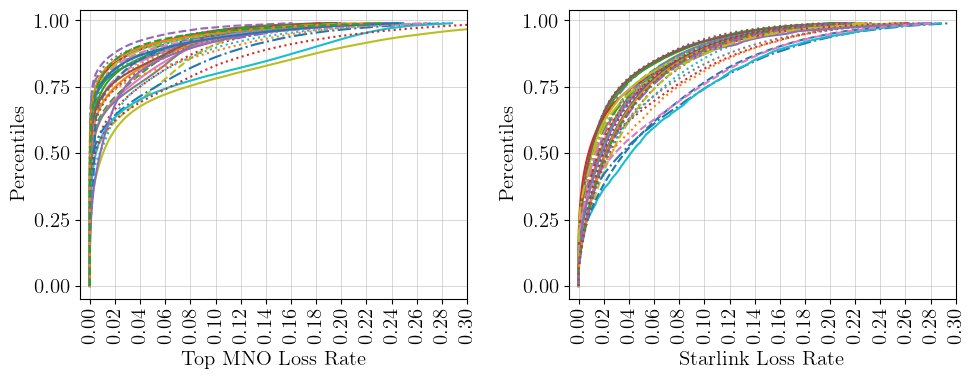

In [84]:
rcParams["font.family"] = "CMU Sans Serif"
# This will compile plots to be Latex compatible
plt.rc('text', usetex=True)
plt.rcParams['image.cmap'] = 'tab10'

#fig, ax = plt.subplots(figsize=(3.37, 2))

matplotlib.rcParams.update({"font.size": 15})
fig, axs = plt.subplots(figsize=(10, 4.04), ncols=2)

data = df.to_dict("records")
ys = [v / 100 for v in range(100)]

lstyles_array = ["solid", "solid", "dashed", "dotted", "dashdot", "dotted"]

i = 0
for idx, row in samecity_df.iterrows():
    if(row["Operator"] == "other"):
        continue
    elif(row["Operator"] == "topmno"):
        continue
    label = "-".join([row["ClientCity"], row["Operator"]])
    #axs[1].plot(row["lossrate_percentiles"][:-1], ys, label=label, linestyle=lstyles_array[i % len(lstyles_array)])
    axs[1].plot(row["lossrate_percentiles"][:-1], ys, label=label, linestyle=lstyles_array[i % len(lstyles_array)])
    i += 1

i = 0
for idx, row in samecity_df.iterrows():
    if(row["Operator"] == "other"):
        continue
    elif(row["Operator"] == "sl"):
        continue
    label = "-".join([row["ClientCity"], row["Operator"]])
    axs[0].plot(row["lossrate_percentiles"][:-1], ys, label=label, linestyle=lstyles_array[i % len(lstyles_array)])
    i += 1
    
axs[0].xaxis.set_tick_params(rotation=90)
axs[1].xaxis.set_tick_params(rotation=90)
    
axs[0].set_yticks([0, 0.25, 0.5, 0.75, 1])
axs[0].set_yticks([0, 0.25, 0.5, 0.75, 1])
axs[1].set_yticks([0, 0.25, 0.5, 0.75, 1])
axs[1].set_yticks([0, 0.25, 0.5, 0.75, 1])
#if xlim:
#    axs[0].set_xlim(0, xlim)
axs[0].set_ylabel("Percentiles")
axs[0].set_xlabel("Top MNO Loss Rate")
axs[1].set_ylabel("Percentiles")
axs[1].set_xlabel("Starlink Loss Rate")
#if title:
#    axs[0].set_title(title)
#axs[0].legend(loc="lower right", fontsize="small", ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
#          columnspacing=0.5, handletextpad=0.3, fancybox=False)
axs[0].grid(True, axis='y', linestyle='-', alpha=0.7, linewidth=0.5)
#axs[1].legend(loc="lower right", fontsize="small", ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
#          columnspacing=0.5, handletextpad=0.3, fancybox=False)
axs[0].set_xticks(np.arange(0, 0.4, 0.02))
axs[1].set_xticks(np.arange(0, 0.4, 0.02))
axs[1].grid(True, axis='y', linestyle='-', alpha=0.7, linewidth=0.5)

axs[0].grid(True, axis='x', linestyle='-', alpha=0.7, linewidth=0.5)
axs[1].grid(True, axis='x', linestyle='-', alpha=0.7, linewidth=0.5)

axs[0].set_xlim((-0.008, 0.3))
axs[1].set_xlim((-0.008, 0.3))

fig.tight_layout()
#if args.save:
#    plt.savefig(args.save, bbox_inches="tight", pad_inches=0)
#else:
plt.show()


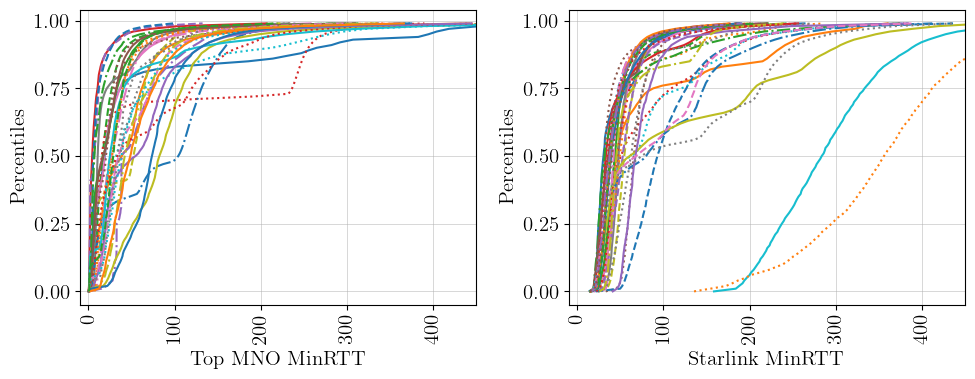

In [85]:
rcParams["font.family"] = "CMU Sans Serif"
# This will compile plots to be Latex compatible
plt.rc('text', usetex=True)
plt.rcParams['image.cmap'] = 'tab10'

#fig, ax = plt.subplots(figsize=(3.37, 2))

matplotlib.rcParams.update({"font.size": 15})
fig, axs = plt.subplots(figsize=(10, 4.04), ncols=2)

data = df.to_dict("records")
ys = [v / 100 for v in range(100)]

lstyles_array = ["solid", "solid", "dashed", "dotted", "dashdot", "dotted"]

i = 0
for idx, row in samecity_df.iterrows():
    if(row["Operator"] == "other"):
        continue
    elif(row["Operator"] == "topmno"):
        continue
    #if row["ClientCity"] == "Manila":
    #    continue
    label = "-".join([row["ClientCity"], row["Operator"]])
    #axs[1].plot(row["lossrate_percentiles"][:-1], ys, label=label, linestyle=lstyles_array[i % len(lstyles_array)])
    #axs[1].plot(row["minrtt_percentiles"][:-1], ys, label=label, linestyle=lstyles_array[i % len(lstyles_array)], color=plt.get_cmap("tab10").colors[0])
    axs[1].plot(row["minrtt_percentiles"][:-1], ys, label=label, linestyle=lstyles_array[i % len(lstyles_array)])
    i += 1

i = 0
for idx, row in samecity_df.iterrows():
    if(row["Operator"] == "other"):
        continue
    elif(row["Operator"] == "sl"):
        continue
    label = "-".join([row["ClientCity"], row["Operator"]])
    #axs[0].plot(row["minrtt_percentiles"][:-1], ys, label=label, linestyle=lstyles_array[i % len(lstyles_array)], color=plt.get_cmap("tab10").colors[1])
    axs[0].plot(row["minrtt_percentiles"][:-1], ys, label=label, linestyle=lstyles_array[i % len(lstyles_array)])
    i += 1
    
axs[0].xaxis.set_tick_params(rotation=90)
axs[1].xaxis.set_tick_params(rotation=90)
    
axs[0].set_yticks([0, 0.25, 0.5, 0.75, 1])
axs[0].set_yticks([0, 0.25, 0.5, 0.75, 1])
axs[1].set_yticks([0, 0.25, 0.5, 0.75, 1])
axs[1].set_yticks([0, 0.25, 0.5, 0.75, 1])
#if xlim:
#    axs[0].set_xlim(0, xlim)
axs[0].set_ylabel("Percentiles")
axs[0].set_xlabel("Top MNO MinRTT")
axs[1].set_ylabel("Percentiles")
axs[1].set_xlabel("Starlink MinRTT")
#if title:
#    axs[0].set_title(title)
#axs[0].legend(loc="lower right", fontsize="small", ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
#          columnspacing=0.5, handletextpad=0.3, fancybox=False)
axs[0].grid(True, axis='y', linestyle='-', alpha=0.7, linewidth=0.5)
#axs[1].legend(loc="lower right", fontsize="small", ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
#          columnspacing=0.5, handletextpad=0.3, fancybox=False)
#axs[0].set_xticks(np.arange(0, 0.4, 0.02))
#axs[1].set_xticks(np.arange(0, 0.4, 0.02))
axs[1].grid(True, axis='y', linestyle='-', alpha=0.7, linewidth=0.5)

axs[0].grid(True, axis='x', linestyle='-', alpha=0.7, linewidth=0.5)
axs[1].grid(True, axis='x', linestyle='-', alpha=0.7, linewidth=0.5)

axs[0].set_xlim((-10.0, 450))
axs[1].set_xlim((-10.0, 450))

fig.tight_layout()
#if args.save:
#    plt.savefig(args.save, bbox_inches="tight", pad_inches=0)
#else:
plt.show()


In [86]:
samecity_df[samecity_df["ClientCity"] == "Manila"]

,ClientCity,Operator,ClientCountryCode,ServerCountryCode,down_queuedelay_percentiles,lossrate_percentiles,minrtt_percentiles,MeasurementCount
326,Manila,topmno,PH,PH,"[0.001, 5.114, 9.237, 14.8, 21.536, 29.526, 37...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 4.739, 5.812, 6.955, 8.04, 9.169, 10.167...",619869
329,Manila,sl,PH,PH,"[0.021, 10.604, 15.713, 20.041, 23.712, 27.089...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0137389671142867e-...","[15.561, 21.064, 22.097, 22.727, 23.189, 23.67...",107780
330,Manila,other,PH,PH,"[0.001, 0.534, 1.135, 1.795, 2.528, 3.344, 4.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.134, 0.982, 1.63, 2.103, 2.562, 2.866, 3.0,...",4439898


## Heatmap

In [587]:
import pandas as pd
#cell_filtered_perf_df = pd.read_csv("data/mlab_mnofiltered_country_agg.csv")
#cell_filtered_perf_df.set_index("CountryName", inplace=True)
cell_all_perf_down_df = pd.read_csv("data/mlab_mno_down_country_agg.csv")
cell_all_perf_up_df = pd.read_csv("data/mlab_mno_up_country_agg.csv")

#cell_all_perf_df.set_index("CountryName", inplace=True)
country_perf_down_df = pd.read_csv("data/mlab_starlink_down_country_agg.csv")
country_perf_down_df.set_index("CountryName", inplace=True)
country_perf_up_df = pd.read_csv("data/mlab_starlink_up_country_agg.csv")
country_perf_up_df.set_index("CountryName", inplace=True)
#country_perf_df.set_index("CountryName", inplace=True)


country_agg_topmno_df = pd.read_csv("data/mlab_mnocell_all_diagnostic.csv")
country_agg_sl_df = pd.read_csv("data/mlab_starlink_country_agg.csv")

In [274]:
import pycountry
import re
import geopandas
import cartopy
import cartopy.crs as ccrs
from matplotlib import colors
from matplotlib.lines import Line2D

countries_name2code = {}
for country in pycountry.countries:
    if re.search("moldova", country.name, re.IGNORECASE):
        #print(country.name)
        countryname = "Moldova"
    elif re.search("saint martin", country.name, re.IGNORECASE):
        #print(country.name)
        countryname = "Saint Martin"
    elif re.search("Virgin Islands, U.S.", country.name, re.IGNORECASE):
        #print(country.name)
        countryname = "U.S. Virgin Islands"
    else:
        countryname = country.name
    countries_name2code[countryname] = country.alpha_2


In [275]:
import json
# Country Codes
with open("data/iso3.json", mode="r", encoding="utf-8") as file:
    f = json.load(file)
country_codes = {value: key for key, value in f.items()} # create mapping from 2-letter to 3-letter country code

In [276]:
joined_country_perf_df = country_perf_up_df.join(country_perf_down_df, lsuffix="_up", rsuffix="_down")

In [277]:
joined_country_perf_df

,avg_latitude_up,avg_longitude_up,avg_minrtt_up,median_minrtt_up,avg_meanthroughputmbps_up,avg_lossraate_up,MostRecentTestTime_up,LeastRecentTestTime_up,TestSpanDays_up,count_measurements_up,avg_latitude_down,avg_longitude_down,avg_minrtt_down,median_minrtt_down,avg_meanthroughputmbps_down,avg_lossraate_down,MostRecentTestTime_down,LeastRecentTestTime_down,TestSpanDays_down,count_measurements_down
CountryName,,,,,,,,,,,,,,,,,,,,
Brazil,-23.533500,-46.635900,929.176755,46.0050,7.253120,0.0,2023-04-30 23:59:00.104042 UTC,2021-12-12 22:37:08.453848 UTC,504,111763,-23.533500,-46.635900,415.769100,43.8810,46.306738,0.053757,2023-04-30 23:58:47.150704 UTC,2021-12-12 22:36:56.948501 UTC,504,141327
Sweden,59.328700,18.071700,87.528339,62.8720,6.795006,0.0,2023-04-30 18:35:09.443552 UTC,2022-04-10 16:59:26.762252 UTC,385,375,59.328700,18.071700,82.983876,61.8640,63.898157,0.043852,2023-04-30 20:02:20.165821 UTC,2022-04-10 16:59:16.082596 UTC,385,517
Mexico,19.432600,-99.133200,1482.761557,84.6820,4.217247,0.0,2023-04-30 23:59:34.283091 UTC,2022-02-24 05:21:26.626759 UTC,430,167595,19.432600,-99.133200,639.363323,82.2270,34.787560,0.058084,2023-04-30 23:59:23.634286 UTC,2022-02-24 05:21:15.201773 UTC,430,213031
Norway,59.865684,10.797534,70.308172,61.2190,7.264885,0.0,2023-04-30 19:35:44.307053 UTC,2022-09-02 12:00:26.564360 UTC,240,658,59.865731,10.797567,68.407346,59.3400,66.726527,0.034855,2023-04-30 21:10:12.608472 UTC,2022-09-02 12:00:15.848524 UTC,240,772
Peru,-12.043534,-77.029723,75.954649,36.3800,8.315663,0.0,2023-04-30 23:14:18.963190 UTC,2022-12-22 15:28:56.355826 UTC,129,3969,-12.043530,-77.029705,73.947152,32.9160,51.634645,0.049067,2023-04-30 23:14:07.342790 UTC,2022-12-22 15:28:44.049524 UTC,129,4550
Greece,37.984200,23.735300,94.180073,92.2430,6.160866,0.0,2023-04-29 19:36:16.727188 UTC,2022-05-30 17:01:50.593773 UTC,334,82,37.984200,23.735300,93.586578,93.2280,76.358484,0.038475,2023-04-29 19:36:03.555762 UTC,2022-05-30 17:01:39.214631 UTC,334,225
Slovenia,46.051525,14.512213,66.685375,62.6805,15.719304,0.0,2022-11-05 09:31:52.832821 UTC,2022-09-04 10:25:30.101508 UTC,61,8,46.051583,14.512575,59.574083,57.4240,44.663797,0.144958,2023-02-06 18:18:35.924965 UTC,2022-09-14 09:08:58.101869 UTC,145,12
Spain,40.416300,-3.693400,266.821464,30.9895,11.002080,0.0,2023-04-30 23:58:03.523358 UTC,2022-04-02 05:54:16.845475 UTC,393,19532,40.416300,-3.693400,360.208547,29.2960,80.342755,0.030466,2023-04-30 23:57:52.164566 UTC,2022-04-02 05:54:04.823300 UTC,393,27242
Nigeria,6.447400,3.390300,493.306903,27.9560,7.200747,0.0,2023-04-30 23:43:56.919349 UTC,2022-11-19 17:40:30.508795 UTC,162,9617,6.447400,3.390300,829.101652,25.4955,55.613179,0.032585,2023-04-30 23:43:44.004199 UTC,2022-11-19 17:40:19.674106 UTC,162,10964


In [278]:
country_agg_sl_df

,CountryName,f0_,avg_latitude,avg_longitude,avg_minrtt,median_minrtt,avg_meanthroughputmbps,avg_lossraate,MostRecentTestTime,LeastRecentTestTime,TestSpanDays,count_measurements
0,Singapore,SG,1.292900,103.854700,50.055909,55.8420,58.133947,0.041292,2023-09-20 07:52:42.531820 UTC,2023-09-13 09:05:54.653463 UTC,6,11
1,Brazil,BR,-23.533500,-46.635900,681.967066,43.8340,28.578509,0.028008,2023-09-30 23:58:55.585534 UTC,2021-12-12 22:36:56.948501 UTC,657,884293
2,Australia,AU,-33.597641,149.472594,491.741559,39.7940,40.355886,0.020163,2023-09-30 23:59:44.885543 UTC,2022-03-11 05:03:05.982105 UTC,568,1287939
3,Mozambique,MZ,-25.970700,32.601000,2519.678460,335.4140,10.958221,0.026953,2023-09-30 20:59:18.952915 UTC,2022-11-07 16:08:17.713719 UTC,327,5887
4,Ireland,IE,53.337936,-6.259100,266.190617,39.4410,45.319198,0.019972,2023-09-30 23:45:58.521075 UTC,2022-02-18 01:34:38.985168 UTC,589,96745
5,Guadeloupe,GP,15.996780,-61.726785,135.717380,135.1285,30.569083,0.023014,2023-09-29 23:37:21.340270 UTC,2022-10-04 21:59:17.794937 UTC,360,1940
6,Finland,FI,60.179700,24.934400,83.066455,82.3640,30.674565,0.030069,2023-09-25 13:35:36.085785 UTC,2023-08-10 10:47:26.397690 UTC,46,22
7,Belgium,BE,50.852251,4.346287,53.272174,42.7150,48.466319,0.018863,2023-09-30 22:25:15.607575 UTC,2022-03-17 05:13:01.121159 UTC,562,37471
8,United States,US,38.914268,-98.687905,288.918484,32.2170,29.291968,0.022520,2023-09-30 23:59:48.544697 UTC,2021-06-30 02:29:10.036432 UTC,822,10685939
9,Indonesia,ID,-6.211400,106.844600,80.659385,66.0470,33.535870,0.020240,2023-09-29 12:53:10.706538 UTC,2023-02-17 02:23:19.570028 UTC,224,403


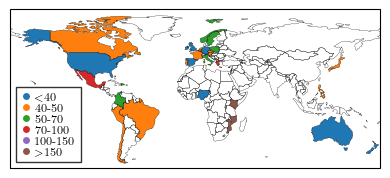

In [310]:
### Generating Example Data
used_df = country_agg_sl_df[country_agg_sl_df["count_measurements"] > 500].reset_index()
used_df = used_df[used_df["CountryName"].isin(countries)]
example_country_data = {countries_name2code[row["CountryName"]]: row["median_minrtt"]  for _, row in used_df.iterrows()}

### Plotting Example Data in Map

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")] # remove Antarctica
    
country_data = []
for name, code in zip(world["name"], world["iso_a3"]):    
    if name == "France":
        country_data.append(example_country_data[country_codes["FRA"]])
    elif name == "Norway":
        country_data.append(example_country_data[country_codes["NOR"]])
    elif code in country_codes and country_codes[code] in example_country_data:
        country_data.append(example_country_data[country_codes[code]])
    else:
        country_data.append(float("NaN"))
world["data"] = country_data

matplotlib.rcParams.update({"font.size": 10})
fig, ax = plt.subplots(figsize=(4, 2), subplot_kw={'projection': ccrs.PlateCarree()})

labels = ["$<$40", "40-50", "50-70", "70-100", "100-150", "$>$150"]
cmap = "tab10"
cols = plt.get_cmap("tab10").colors[:6]
cmap = colors.ListedColormap(cols)
handles = [Line2D([0], [0], marker="o", color="w", markerfacecolor=col)
           for col in cols]
ax.legend(handles, labels, handlelength=1, labelspacing=0.06, columnspacing=0.5, handletextpad=0.3,
          loc="lower left", fancybox=False, edgecolor="k", fontsize="small")

world.plot(facecolor ="#00000000", ax=ax, edgecolor="black", linewidth=0.2)
world.plot(column="data", cmap=cmap, scheme='UserDefined', 
           classification_kwds=dict(bins=[40,50,70,100, 150, 99999999]), zorder=0, ax=ax)
ax.set_extent([-180, 180, -60, 90], ccrs.PlateCarree())
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

fig.tight_layout()
plt.savefig("figures/mlab_mapped_medianminrtt_oneyear_heatmap.pdf", bbox_inches="tight", pad_inches=0)
plt.savefig("figures/mlab_mapped_medianminrtt_oneyear_heatmap.svg", bbox_inches="tight", pad_inches=0)
plt.show()

In [325]:
used_df_1 = country_agg_sl_df[country_agg_sl_df["count_measurements"] > 500].reset_index()
used_df_2 = country_agg_topmno_df[country_agg_topmno_df["count_measurements"] > 500]
set(used_df_1["CountryName"]).difference(used_df_2["CountryName"])

#set(countries).difference(

{'Czechia',
 'Greece',
 'Guadeloupe',
 'Kenya',
 'Martinique',
 'Mozambique',
 'Poland',
 'Saint Barthélemy',
 'Sweden'}

In [319]:
used_df["CountryName"]

0                 Mexico
1                 Brazil
2            Puerto Rico
3               Colombia
4                Belgium
5              Australia
7                 Norway
8                   Peru
9                Ireland
10                France
11        United Kingdom
12                 Chile
13           Philippines
14               Nigeria
15               Austria
16           Netherlands
17                Canada
18    Dominican Republic
19               Germany
20         United States
21           New Zealand
22                 Italy
23                 Spain
25              Portugal
26                 Japan
Name: CountryName, dtype: object

           CountryName  median_minrtt
23         Netherlands         8.5320
9          New Zealand         9.4480
0               Poland        11.2720
3              Ireland        12.8120
22               Kenya        13.0790
11      United Kingdom        13.0910
12              France        13.2510
18             Belgium        15.2630
14              Greece        16.4175
13               Spain        17.2790
21              Canada        17.5230
2              Germany        18.2240
16              Norway        18.2920
32             Czechia        18.8270
27              Sweden        20.0120
6             Portugal        20.3180
5            Australia        23.8050
30             Nigeria        24.2540
10               Japan        25.1460
8                Italy        25.9600
29               Chile        28.4680
31             Austria        30.2870
17              Brazil        34.8590
25       United States        37.3830
15                Peru        37.4900
28         P

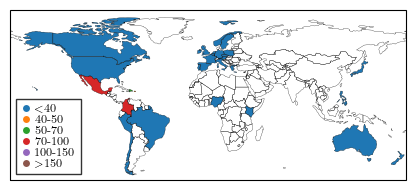

In [588]:
### Generating Example Data
used_df = country_agg_topmno_df[country_agg_topmno_df["count_measurements"] > 500]
used_df = used_df[used_df["CountryName"].isin(countries)]
used_df = used_df[~used_df["CountryName"].isin(["Martinique", "Saint Barthélemy"])]
example_country_data = {countries_name2code[row["CountryName"]]: row["median_minrtt"]  for _, row in used_df.iterrows()}

print(used_df[["CountryName", "median_minrtt"]].sort_values("median_minrtt"))

### Plotting Example Data in Map

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")] # remove Antarctica
    
country_data = []
for name, code in zip(world["name"], world["iso_a3"]):    
    if name == "France":
        country_data.append(example_country_data[country_codes["FRA"]])
    elif name == "Norway":
        country_data.append(example_country_data[country_codes["NOR"]])
    elif code in country_codes and country_codes[code] in example_country_data:
        country_data.append(example_country_data[country_codes[code]])
    else:
        country_data.append(float("NaN"))
world["data"] = country_data

fig, ax = plt.subplots(figsize=(4.66, 2), subplot_kw={'projection': ccrs.PlateCarree()})

labels = ["$<$40", "40-50", "50-70", "70-100", "100-150", "$>$150"]
cmap = "tab10"
cols = plt.get_cmap("tab10").colors[:6]
cmap = colors.ListedColormap(cols)
handles = [Line2D([0], [0], marker="o", color="w", markerfacecolor=col)
           for col in cols]
ax.legend(handles, labels, handlelength=1, labelspacing=0.06, columnspacing=0.5, handletextpad=0.3,
          loc="lower left", fancybox=False, edgecolor="k", fontsize="small")

world.plot(facecolor ="#00000000", ax=ax, edgecolor="black", linewidth=0.2)
world.plot(column="data", cmap=cmap, scheme='UserDefined', 
           classification_kwds=dict(bins=[40,50,70,100, 150, 99999999]), zorder=0, ax=ax)
ax.set_extent([-180, 180, -60, 90], ccrs.PlateCarree())
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

fig.tight_layout()
# The bins have been manually editted, ....
plt.savefig("figures/mlab_mnocell-all_mapped_medianminrtt_heatmap.pdf", bbox_inches="tight", pad_inches=0)
plt.savefig("figures/mlab_mnocell-all_mapped_medianminrtt_heatmap.svg", bbox_inches="tight", pad_inches=0)
plt.show()

In [459]:
trace_tput_df = pd.read_csv("data/traceroute_join_countrycity.csv")

def apply_str_to_list(s: str):
    s = s[1:-1]
    l = [float(num.strip()) for num in s.split(",")]
    return l

def apply_extract_median(arr: list):
    return arr[len(arr)//2]

trace_tput_df["stl_rtt_fraction"] = trace_tput_df["stl_rtt_fraction"].apply(apply_str_to_list)
trace_tput_df["stl_rtt"] = trace_tput_df["stl_rtt"].apply(apply_str_to_list)
trace_tput_df["median_stl_rtt"] = trace_tput_df["stl_rtt"].apply(apply_extract_median)
trace_tput_df["median_stl_rtt_fraction"] = trace_tput_df["stl_rtt_fraction"].apply(apply_extract_median)
#trace_tput_df = trace_tput_df[trace_tput_df["cityC"].isin(interesting_cities)]
trace_tput_df = trace_tput_df[trace_tput_df["countryC"].isin(countries_code)]
trace_tput_df.sort_values("cnt", ascending=False)

,cnt,countryC,cityC,dist_km,stl_rtt_fraction,stl_rtt,min_rtt,trace_rtt,num_hops,tput_mbps,dl_mbps,ul_mbps,loss_rate,median_stl_rtt,median_stl_rtt_fraction
175,1921102,US,Seattle,17.346849,"[0.01, 42.8, 84.62, 92.28, 97.6, 97.83, 97.97,...","[0.0020000000000024443, 18.712, 19.544, 20.163...",30.665,0.295,5,9.737493,36.397503,4.527121,0.000413,30.149,99.07
117,1899373,US,Chicago,24.747725,"[0.01, 36.08, 53.96, 64.29, 78.46, 91.86, 92.6...","[0.0030000000000001137, 14.248999999999999, 18...",34.302,0.338,6,10.065709,36.907954,4.731187,0.000751,33.007,98.94
111,1653781,US,Atlanta,23.515289,"[0.0, 64.54, 87.05, 98.55, 98.65, 98.71, 98.75...","[0.0009999999999976694, 19.25, 20.759, 21.715,...",32.718,0.261,5,8.249735,28.576786,3.887207,0.000791,32.262,99.22
124,1628998,US,Dallas,26.124749,"[0.01, 93.97, 95.29, 96.31, 96.8, 97.08, 97.27...","[0.003999999999997783, 19.28, 19.9749999999999...",31.724,0.252,5,8.475519,29.771688,3.851679,0.000851,31.296,99.21
71,1605226,CA,Toronto,16.952010,"[0.02, 45.67, 52.14, 54.39, 55.81, 56.79, 57.6...","[0.006000000000000227, 18.649, 20.397, 21.4350...",49.712,14.694,6,10.539227,42.076077,4.625994,0.000437,34.463,70.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,2,US,Paso Robles,282.011795,"[98.92, 98.92, 98.92, 98.92, 98.92, 98.92, 98....","[31.158, 31.158, 31.158, 31.158, 31.158, 31.15...",31.498,0.340,7,4.144403,13.102700,4.144403,0.000000,31.158,98.92
12,2,AU,Flinders,740.563259,"[96.82, 96.82, 96.82, 96.82, 96.82, 96.82, 96....","[39.138999999999996, 39.138999999999996, 39.13...",40.425,1.286,5,6.392595,112.225357,6.392595,0.000000,39.139,96.82
37,1,AU,Orangeville,54.229115,"[9.81, 9.81, 9.81, 9.81, 9.81, 9.81, 9.81, 9.8...","[22.52799999999999, 22.52799999999999, 22.5279...",229.641,207.113,7,25.524992,25.524992,NaN,0.055360,22.528,9.81
150,1,US,Leitchfield,520.236797,"[33.61, 33.61, 33.61, 33.61, 33.61, 33.61, 33....","[20.880000000000003, 20.880000000000003, 20.88...",62.116,41.236,8,29.153731,29.153731,NaN,0.161505,20.880,33.61


{'AU': 35.20858181818182, 'BE': 31.065999999999995, 'BG': 54.73, 'BR': 39.142, 'CA': 43.2566875, 'CH': 36.85, 'CL': 31.918, 'CO': 31.855, 'CZ': 34.52, 'DE': 31.899, 'ES': 29.1, 'FI': 49.36599999999999, 'FR': 33.56, 'GB': 28.086, 'GR': 53.50299999999999, 'IE': 29.189, 'IT': 42.954, 'JP': 34.832, 'KE': 98.70000000000002, 'MX': 31.9116, 'MZ': 119.726, 'NG': 25.428, 'NL': 31.963, 'NO': 36.646, 'NZ': 25.118000000000002, 'PE': 29.27, 'PH': 30.116, 'PL': 40.149, 'PT': 28.861500000000007, 'SE': 37.513, 'SI': 45.234, 'US': 30.570756097560977}


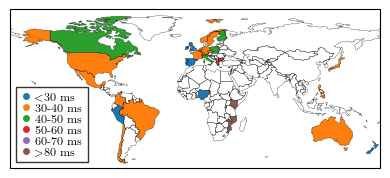

In [462]:
### Generating Example Data

used_df = trace_tput_df[["countryC", "median_stl_rtt"]].groupby("countryC").mean()
example_country_data = {code: row["median_stl_rtt"]  for code, row in used_df.iterrows()}

print(example_country_data)
### Plotting Example Data in Map

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")] # remove Antarctica
    
country_data = []
for name, code in zip(world["name"], world["iso_a3"]):    
    if name == "France":
        country_data.append(example_country_data[country_codes["FRA"]])
    elif name == "Norway":
        country_data.append(example_country_data[country_codes["NOR"]])
    elif code in country_codes and country_codes[code] in example_country_data:
        country_data.append(example_country_data[country_codes[code]])
    else:
        country_data.append(float("NaN"))
world["data"] = country_data

matplotlib.rcParams.update({"font.size": 10})
fig, ax = plt.subplots(figsize=(4, 2), subplot_kw={'projection': ccrs.PlateCarree()})

#labels = ["$<$40", "40-50", "50-70", "70-100", "100-150", "$>$150"]
#labels = ["$<$25", "25-35", "35-40","40-50", "50-60", "60-80", "$>$80"]
classification_bins = [30,40,50,60, 70, 80, 99999999]
def label_gen(suffix=""):
    labels = []
    for i, n in enumerate(classification_bins):
        if i == 0:
            labels.append(f"$<${n}{suffix}")
        elif i == len(classification_bins) - 2:
            labels.append(f"$>${n}{suffix}")
            break
        else:
            labels.append(f"{classification_bins[i-1]}-{n}{suffix}")
    return labels
labels = label_gen(suffix=" ms")
cmap = "tab10"
cols = plt.get_cmap("tab10").colors[:len(labels)]
cmap = colors.ListedColormap(cols)
handles = [Line2D([0], [0], marker="o", color="w", markerfacecolor=col)
           for col in cols]
ax.legend(handles, labels, handlelength=1, labelspacing=0.06, columnspacing=0.5, handletextpad=0.3,
          loc="lower left", fancybox=False, edgecolor="k", fontsize="small")

world.plot(facecolor ="#00000000", ax=ax, edgecolor="black", linewidth=0.2)
world.plot(column="data", cmap=cmap, scheme='UserDefined', 
           classification_kwds=dict(bins=classification_bins), zorder=0, ax=ax)
ax.set_extent([-180, 180, -60, 90], ccrs.PlateCarree())
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

fig.tight_layout()
plt.savefig("figures/mlab_median-starlink-rtt_heatmap.pdf", bbox_inches="tight", pad_inches=0)
plt.savefig("figures/mlab_median-starlink-rtt_heatmap.svg", bbox_inches="tight", pad_inches=0)
plt.show()

<Axes: >

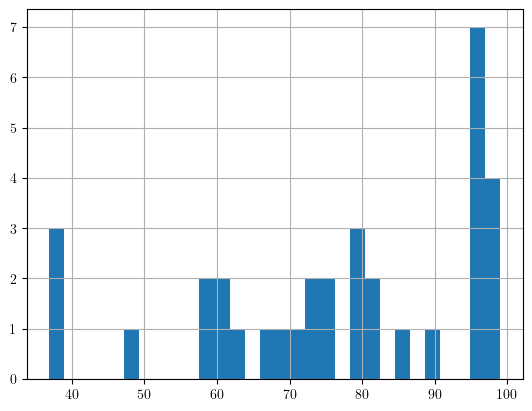

In [302]:
used_df = trace_tput_df[["countryC", "median_stl_rtt_fraction"]].groupby("countryC").mean()
used_df["median_stl_rtt_fraction"].hist(bins=30)

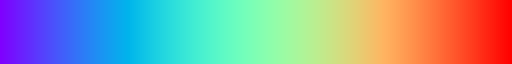

In [473]:
asdasd = matplotlib.colormaps["rainbow"]
asdasd

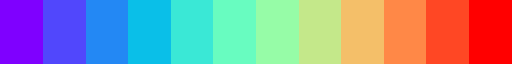

In [491]:
custom_cmap

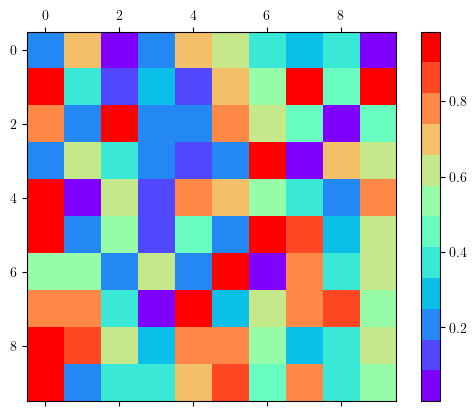

In [490]:

# Import the rainbow colormap
cmap = plt.get_cmap("rainbow")

# Define the percentage of colors you want to extract (20% in this case)
percentage = 0.05

# Create a custom colormap with the desired percentage of colors
num_colors = int(cmap.N * percentage)
custom_cmap = plt.cm.colors.ListedColormap(cmap(np.linspace(0, 1, num_colors)))

# Example usage: create a colorbar with the custom colormap
fig, ax = plt.subplots()
cax = ax.matshow(np.random.random((10, 10)), cmap=custom_cmap)
plt.colorbar(cax)

plt.show()

In [575]:
used_df.sort_values("median_stl_rtt_fraction")

,median_stl_rtt_fraction
countryC,
MZ,36.890000
MX,38.038000
KE,38.830000
GR,58.540000
NO,58.690000
FI,59.970000
SE,61.780000
BG,67.560000
PT,69.990000


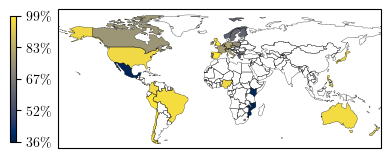

In [581]:
### Generating Example Data

used_df = trace_tput_df[["countryC", "median_stl_rtt_fraction"]].groupby("countryC").mean()
example_country_data = {code: (row["median_stl_rtt_fraction"] - min(used_df["median_stl_rtt_fraction"] )) / (max(used_df["median_stl_rtt_fraction"]) - min(used_df["median_stl_rtt_fraction"]))  for code, row in used_df.iterrows()}

### Plotting Example Data in Map

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")] # remove Antarctica
    
country_data = []
for name, code in zip(world["name"], world["iso_a3"]):    
    if name == "France":
        country_data.append(example_country_data[country_codes["FRA"]])
    elif name == "Norway":
        country_data.append(example_country_data[country_codes["NOR"]])
    elif code in country_codes and country_codes[code] in example_country_data:
        country_data.append(example_country_data[country_codes[code]])
    else:
        country_data.append(float("NaN"))
world["data"] = country_data

matplotlib.rcParams.update({"font.size": 10})
fig, ax = plt.subplots(figsize=(4.8, 2.4), subplot_kw={'projection': ccrs.PlateCarree()})

#labels = ["$<$40", "40-50", "50-70", "70-100", "100-150", "$>$150"]
#labels = ["$<$25", "25-35", "35-40","40-50", "50-60", "60-80", "$>$80"]
classification_bins = np.linspace(0, 100, 100)
def label_gen(suffix = ""):
    labels = []
    for i, n in enumerate(classification_bins):
        if i == 0:
            labels.append(f"$<${n}{suffix}")
        elif i == len(classification_bins) - 2:
            labels.append(f"{classification_bins[i-1]}-{n}{suffix}")
            break
        else:
            labels.append(f"{classification_bins[i-1]}-{n}{suffix}")
    return labels
labels = label_gen(suffix = " \%")
#cmap = "tab10"
#cols = plt.get_cmap("tab10").colors[:len(labels)]
#cols = plt.get_cmap("rainbow").colors[:len(labels)]
#cmap = colors.ListedColormap(cols)
cmap = matplotlib.colormaps["cividis"]
#cmap = 'gray'
handles = [Line2D([0], [0], marker="o", color="w", markerfacecolor=col)
           for col in cols]
#ax.legend(handles, labels, handlelength=1, labelspacing=0.06, columnspacing=0.5, handletextpad=0.3,
#          loc="lower left", fancybox=False, edgecolor="k", fontsize="small")

world.plot(facecolor ="#00000000", ax=ax, edgecolor="black", linewidth=0.2)
asd = world.plot(column="data", cmap=cmap, zorder=0, ax=ax)

#plt.colorbar(ax=ax, cmap=cmap)
cmap_abs_range = np.linspace(min(used_df["median_stl_rtt_fraction"]), max(used_df["median_stl_rtt_fraction"]), 5)
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=None, cmap=cmap), ax=asd, shrink=0.6, anchor=(-7.2, 0.5))
cbar.set_ticks(ticks=np.linspace(0, 1, len(cmap_abs_range)), labels=[f"{int(n)}\%" for n in cmap_abs_range])

ax.set_extent([-180, 180, -60, 90], ccrs.PlateCarree())
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

fig.tight_layout()
plt.savefig("figures/mlab_median-starlink-rtt-fraction_heatmap.pdf", bbox_inches="tight", pad_inches=0)
plt.savefig("figures/mlab_median-starlink-rtt-fraction_heatmap.svg", bbox_inches="tight", pad_inches=0)
plt.show()

<Axes: >

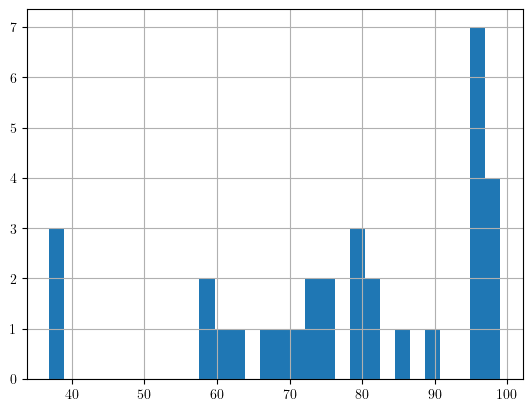

In [571]:
used_df["median_stl_rtt_fraction"].hist(bins=30)

In [566]:
example_country_data

#cmap_abs_range = np.linspace(min(used_df["median_stl_rtt_fraction"]), max(used_df["median_stl_rtt_fraction"]), 5)


{'AU': 0.9494409647017502,
 'BE': 0.6020605280103027,
 'BG': 0.49372182871860915,
 'BR': 0.9573406310367031,
 'CA': 0.6312379265936895,
 'CH': 0.7912105602060528,
 'CL': 0.9890534449452671,
 'CO': 0.9438184159690919,
 'CZ': 0.6685447520927237,
 'DE': 0.7070186735350933,
 'ES': 0.984707018673535,
 'FI': 0.3715389568576947,
 'FR': 0.6725692208628461,
 'GB': 1.0,
 'GR': 0.3485189954925949,
 'IE': 0.593689632968448,
 'IT': 0.6885061171925305,
 'JP': 0.9570186735350933,
 'KE': 0.03122987765614935,
 'MX': 0.01848036059240174,
 'MZ': 0.0,
 'NG': 0.937862202189311,
 'NL': 0.7126529298132646,
 'NO': 0.3509336767546683,
 'NZ': 0.8362041210560207,
 'PE': 0.9929169349645844,
 'PH': 0.9560528010302639,
 'PL': 0.5763039278815195,
 'PT': 0.5328396651641982,
 'SE': 0.40067611075338055,
 'SI': 0.5387958789439793,
 'US': 0.9421026180641714}

<Axes: >

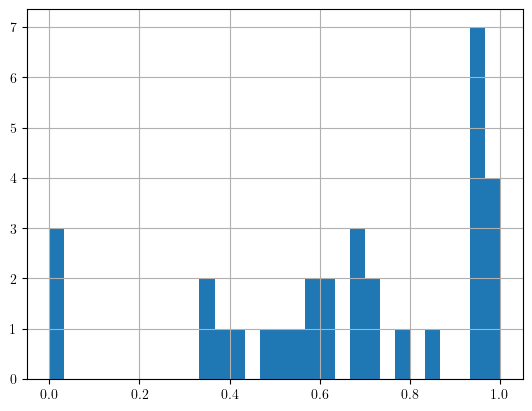

In [554]:
world[~world["data"].isnull()]["data"].hist(bins=30)

In [535]:
cmap(1.5)

(1.0, 1.2246467991473532e-16, 6.123233995736766e-17, 1.0)

In [121]:
country_agg_topmno_df.rename(columns={country_agg_topmno_df.columns[1]:"CountryCode"})
country_agg_sl_df.rename(columns={country_agg_sl_df.columns[1]:"CountryCode"})

,CountryName,CountryCode,avg_latitude,avg_longitude,avg_minrtt,median_minrtt,avg_meanthroughputmbps,avg_lossraate,MostRecentTestTime,LeastRecentTestTime,TestSpanDays,count_measurements
0,Peru,PE,-12.043532,-77.029713,74.593492,34.4560,31.330975,0.026105,2023-04-30 23:14:18.963190 UTC,2022-12-22 15:28:44.049524 UTC,129,8552
1,Norway,NO,59.865766,10.797590,69.040591,60.0050,39.228692,0.018751,2023-04-30 21:10:12.608472 UTC,2022-09-02 12:00:15.848524 UTC,240,1435
2,Netherlands,NL,52.375148,4.895891,45.877564,39.8125,42.396782,0.021206,2023-04-30 18:08:35.966083 UTC,2022-03-17 11:08:32.356560 UTC,409,9702
3,Dominican Republic,DO,18.462905,-69.892366,70.202859,65.4680,30.167495,0.030419,2023-04-30 23:37:38.238404 UTC,2022-08-14 01:50:30.778199 UTC,259,6977
4,Kenya,KE,-1.284100,36.815500,407.086000,390.6765,9.678349,0.011255,2023-04-27 08:39:21.917867 UTC,2023-04-17 09:58:15.225784 UTC,9,6
5,Canada,CA,46.114801,-91.912607,382.062358,47.9770,35.435985,0.021803,2023-04-30 23:59:35.049282 UTC,2021-09-19 04:07:02.760988 UTC,588,1665647
6,Philippines,PH,14.601900,120.989600,190.765655,157.3240,18.327661,0.027587,2023-04-30 23:51:59.392923 UTC,2022-12-07 05:01:34.287516 UTC,144,25698
7,Chile,CL,-33.451460,-70.662967,714.877629,56.8810,30.891460,0.024338,2023-04-30 23:29:49.560796 UTC,2022-03-17 04:18:35.540836 UTC,409,75182
8,Mozambique,MZ,-25.970700,32.601000,427.064182,436.2200,8.157041,0.018660,2023-04-06 16:51:57.972990 UTC,2022-11-07 16:08:17.713719 UTC,150,33
9,Ireland,IE,53.337950,-6.259100,293.059330,39.3740,46.838466,0.020197,2023-04-30 23:59:20.927747 UTC,2022-02-18 01:34:38.985168 UTC,436,68964


In [130]:
buckets = [40, 50, 70, 100, 150, 999999]

last_limit = 0
for i in range(len(buckets)):
    print("..............")
    print("{}<{}".format(last_limit, buckets[i]))
    print(len(used_df[(used_df["median_minrtt"] > last_limit) & (used_df["median_minrtt"] < buckets[i])]))
    print("..............")
    last_limit = buckets[i]

..............
0<40
21
..............
..............
40<50
1
..............
..............
50<70
1
..............
..............
70<100
2
..............
..............
100<150
2
..............
..............
150<999999
0
..............


## Weather Report

- https://en.wikipedia.org/wiki/December_2022_North_American_winter_storm

- https://en.wikipedia.org/wiki/2022%E2%80%9323_North_American_winter

In [ ]:
# Dec 21-26 2022

# Sept 21-26  2022

# TBD
lat_bounds = ()
lon_bounds = ()

## Boxplots

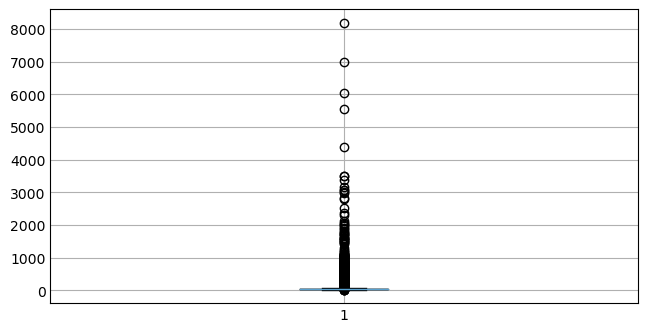

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('_mpl-gallery')

# make data:
#np.random.seed(10)
#arr1 = np.random.normal(5, 1, size=(10,))
#arr2 = np.random.normal(3, 3, size=(10,))
#arr3 = np.random.normal(10, 0.3, size=(10,))
#arr4 = np.random.normal(4, 5, size=(10,))

#columns = [
#    df[df["ClientCity"] == "Mexico City"]["MinRTT"],
#    df[df["ClientCity"] == "Bogotá"]["MinRTT"],
#    df[df["ClientCity"] == "Oslo"]["MinRTT"],
#    df[df["ClientCity"] == "Seattle"]["MinRTT"],
#    df[df["ClientCity"] == "Sydney"]["MinRTT"]
#]

columns = [df[(df["ClientCity"] == "Berlin") & (df["MinRTT"] < 100000)]["MinRTT"]]

fig, ax = plt.subplots(figsize=(6, 3))
ax.boxplot(columns)
plt.show()

In [7]:
def row2box(row, attr, usestd = True):
    median = row["{}_q2".format(attr)]
    
    if(usestd):
        q0 = median - row["{}_stddev".format(attr)]
        q0 = 0 if q0 < 0 else q0
        q4 = median + row["{}_stddev".format(attr)]
    else:
        q0 = row["{}_q0".format(attr)]
        q0 = 0 if q0 < 0 else q0
        q4 = row["{}_q4".format(attr)]
        q4 = row["{}_q3".format(attr)]
    
    return {
        'label' : row.name,
        'whislo': q0,# Bottom whisker position
        'q1'    : row["{}_q1".format(attr)],             # First quartile (25th percentile)
        'med'   : median,                                # Median         (50th percentile)
        'q3'    : row["{}_q3".format(attr)],             # Third quartile (75th percentile)
        'whishi': q4,    # Top whisker position
        'fliers': []                                     # Outliers
    }

def visualize_boxplot(df, attr, save=False, usestd=True):
    fig, ax = plt.subplots(figsize=(6, 3))
    boxes = [row2box(row, attr, usestd=usestd) for idx, row in df.iterrows()]
    ax.bxp(boxes, showfliers=False)
    
    if(attr == "MeanThroughputMbps"):
        ax.set_ylabel("Mean Throughput in Mbps")
    elif(attr == "MinRTT"):
        ax.set_ylabel("Min RTT in milliseconds")
    elif(attr == "lossrate"):
        ax.set_ylabel("Lossrate from the lifetime of the connection")
    
    if(save):
        plt.tight_layout()
        plt.savefig("mlab_{}_starlink_boxplot.pdf".format(attr))
    plt.show()
    
    
# [x] Filter Edge-Cases:
    # MinRTT = -1
    # Meanthroughput = 0.0
    # lossrate = -1
# [ ] Inverstigate Max value, put those into outliers
    # Maximum values are probably better in a spearate plot
# TODO: [x] Use Standard Deviation instead of Maximum/Minimum
# [ ] Compare throughput latencies reported over Cellular Networks with the ones over Starlink
    # https://github.com/tkdang97/Cloudy-with-a-Chance-of-Short-RTTs/blob/main/speedchecker-analysis.ipynb
    # Associated Dataset
        # Compare ISPs by looking at probes that connect to the same endpoint
            # Throughput, Latency/RTT
        # Use above information to compare the ISP to Starlink
# [ ] Sync Throughput Count Map with availability
# 


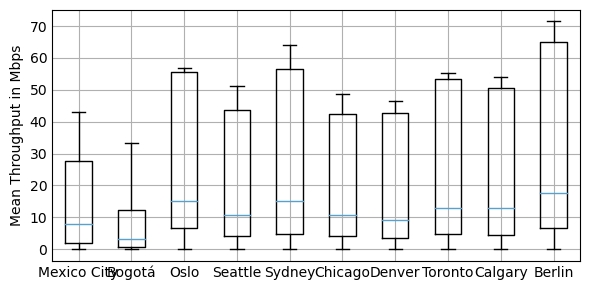

In [8]:
visualize_boxplot(df, "MeanThroughputMbps", save=True)

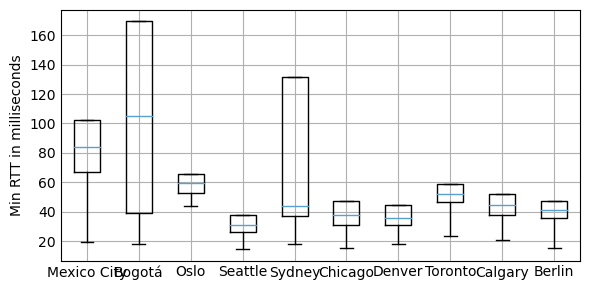

In [11]:
# This might be a bit interesting as CDF
#   - 75th percentile being lower than others 25th percentile
#   - long tail, from 75th percentile to max, there are interesting things going on

# Sydney vs. Seattle
#   - Satellite Density
#   - Gateway Distribution
#   - Groundstation Availability

# 2019 - 2022
visualize_boxplot(df, "MinRTT", save=True, usestd=False)

In [12]:
# 2019 - 2022
df["measurement_count"].sum()

3668876

In [13]:
# 2021 - 2022
df["measurement_count"].sum()

3668876

In [14]:
1483238 - 1467264

15974

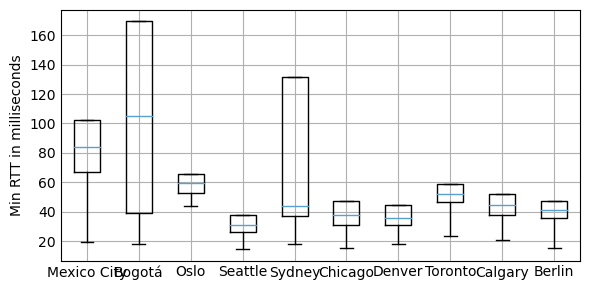

In [15]:
# 2021 - 2022
visualize_boxplot(df, "MinRTT", save=True, usestd=False)

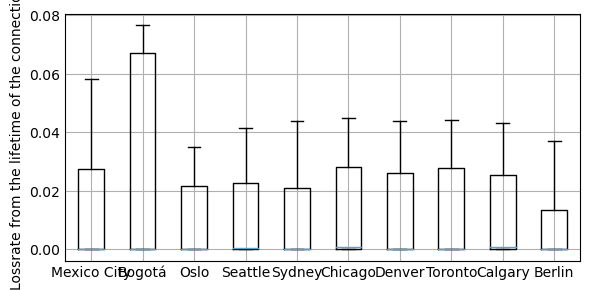

In [16]:
visualize_boxplot(df, "lossrate", save=True)